In [71]:
import os
import json
import ast
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pathlib
import pprint
import scipy
from datetime import datetime
import sys
import shutil
import random
from scipy.interpolate import interp1d
from scipy import stats

# Prep

## Training Catalog

In [72]:
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [73]:
DRL_TRAININGS = {
    "reward_sharpe_ratio_0": "20230429_200721",
    "reward_differential_sharpe_ratio_0": "20230424_070731",
    "compute_reward_from_tutor_0": "20230429_200559",
    "reward_profit_0": "20230429_110440",
    "reward_profit_1": "20230423_174023",
    "reward_profit_2": "20230420_083508", # trial 8
    "reward_profit_3": "20230420_195053", # trial 9
}

DQN_TRAININGS = {
    "reward_sharpe_ratio_0": "20230427_165557",
    "reward_differential_sharpe_ratio_0": "20230427_083418",
    "compute_reward_from_tutor_0": "20230427_083632",
    "reward_profit_0": "20230425_145617",

    "reward_differential_sharpe_ratio_1": "20230423_114422",
    "compute_reward_from_tutor_1": "20230421_181519",
    "reward_profit_1": "20230423_231505",
    "reward_profit_2": "20230422_122001",
    "reward_profit_3": "20230421_001115",
}


**Prep data folder for notebook** 
 - Copy all trainings to one folder. It can be any folder, just set the vairable "base_folder" as the full path to that folder.
 - Set folder to var base_folder 
Folder should look like:
```
base_folder/
| 20230429_200721
| 20230424_070731
| ...

In [74]:
base_folder = pathlib.Path(r'C:\\Users\\romy_\\Documents\\arnolduni\\ai_trader_data')

# algo='drl'
# algo='dqn'

data_folder = os.path.join(base_folder, '20230427_165557')
print(data_folder, os.path.exists(data_folder))

trial_name = [x for x in os.listdir(data_folder) if os.path.isdir(os.path.join(data_folder, x))][0]

data = json.load(open(os.path.join(data_folder, trial_name, 'params.json')))
print(data['reward_function'])

C:\Users\romy_\Documents\arnolduni\ai_trader_data\20230427_165557 True
reward_sharpe_ratio


```
print(train_frame_drl.columns)
Index(['episode', 'run', 'action', 'state', 'reward', 'done', 'epsilon',
       'profit', 'time_elapsed'],
      dtype='object') 

print(ep_frame_drl.columns)
Index(['wallet_value', 'buy_short_count', 'long_wallet', 'btc_price',
       'btc_units', 'state', 'money', 'funding_rate', 'short_position',
       'reward', 'btc_eur', 'sell_long_count', 'product_price', 'short_wallet',
       'done', 'sell_short_count', 'buy_long_count', 'action', 'short_eur',
       'long_position', 'fee_paid', 'episode', 'short_units'],
      dtype='object')

In [75]:
dict_reward_plots = dict()

## Helper Functions

In [76]:
def get_train_data(path_to_folders, algorithm, trial=0, return_df=True):
    trial_name = [x for x in os.listdir(path_to_folders) if os.path.isdir(os.path.join(data_folder, x))]
    if trial_name:
        trial_name = trial_name[0]
    else:
        trial_name = f"{algorithm.upper()}_trial_{trial}"
    r_funcs = []

    data = json.load(open(os.path.join(path_to_folders, trial_name, 'params.json')))
    r_funcs.append(data['reward_function'])
    pprint.pprint(data)

    path_to_episode_files = os.path.join(path_to_folders, trial_name, "episodes")
    files_ep = os.listdir(path_to_episode_files)
    ep_li = []
    for file in files_ep:
        df = pd.read_csv(os.path.join(path_to_episode_files, file), sep=";", index_col=None, header=0)
        ep_li.append(df)
    ep_frame = pd.concat(ep_li, axis=0, ignore_index=True)

    files_tr = os.listdir(os.path.join(path_to_folders, trial_name))
    tr_li = []
    for filename in files_tr:
        if filename.endswith(".csv"):
            df = pd.read_csv(os.path.join(path_to_folders, trial_name, filename), sep=";", index_col=None, header=0)
            tr_li.append(df)
    train_frame = pd.concat(tr_li, axis=0, ignore_index=True)

    if return_df:
        return train_frame, ep_frame
    else:
        return files_tr, files_ep


In [77]:
def get_profits_every_episode(dataframe):
    profit = []
    episode = []
    delta_btc_price = []
    grouped = dataframe.groupby('episode')
    for name, group in grouped:
        btc_price_init = group.iloc[0]['btc_price']
        btc_price_final = group.iloc[-1]['btc_price']
        # n_btc =  10000 / btc_price_init
        wallet_value_init = group.iloc[0]['wallet_value']
        wallet_value_final = group.iloc[-1]['wallet_value']
        episode.append(int(name))
        profit.append(wallet_value_final - wallet_value_init)
        # delta_btc_price.append(btc_price_final*n_btc - 10000)
        delta_btc_price.append(btc_price_final - btc_price_init)

    return episode, profit, delta_btc_price

In [78]:
def plot_overviews(episode, profit, delta_btc_price,n_conv = 5, save_name=None, algo='DQN'):
    print(algo)
    print("np.mean(profit), np.std(profit), np.max(profit), np.min(profit),, letzte(profit)")
    print(f"{algo} & {np.round(np.mean(profit), 2)} & {np.round(np.std(profit), 2)} & {np.round(np.max(profit), 2)} & {np.round(np.min(profit), 2)} & {np.round(np.mean(profit[-5:]), 2)} ")
    print("np.mean(delta_btc_price), np.std(delta_btc_price), np.max(delta_btc_price), np.min(delta_btc_price), letzte(delta_btc_price)")
    print(f"B&H & {np.round(np.mean(delta_btc_price), 2)} & {np.round(np.std(delta_btc_price), 2)} & {np.round(np.max(delta_btc_price), 2)} & {np.round(np.min(delta_btc_price), 2)} & {np.round(np.mean(delta_btc_price[-5:]), 2)} ")
    print(algo)

    # print("profit_diff = profit_algo -   profit_B&H")
    profit_diff = [profit[i] - delta_btc_price[i] for i in range(len(episode))]
    episode = [i for i in range(len(episode))]
    fig, ax = plt.subplots(2,1, figsize=(16,8), sharex=True)
    if algo == 'DQN':
        c_algo = 'k'
    else:
        c_algo = 'b'
    # Fig 1 profits and BTC prices delta
    ax[0].plot(episode, profit, color=c_algo, label=algo)
    ax[0].plot(episode, delta_btc_price, color='m', label='B&H')
    ax[0].set_title(f"Profit {algo} und B&H über die Episoden")
    ax[0].set_xlabel("Episode [-]")
    ax[0].set_ylabel("Profit [Eur]")
    ax[0].set_xlim([0,max(episode)])
    ax[0].legend()
    ax[0].grid()

    tmp_diff = np.convolve(profit_diff, np.ones(5)/5, mode='valid')
    print(tmp_diff.shape)
    x_tmp_diff = [i for i in range(len(tmp_diff))]
    color = ['r' if y<0 else 'g' for y in tmp_diff]
    # Fig 2 profit dif to btc and BTC prices delta
    # ax[0][1].plot(profit_diff)
    # # ax[0][1].plot(tmp)
    # # ax[0][1].hist(profit_diff, bins=20)
    # ax[0][1].set_title("Comparison from NN to Buy-&-Hold over Episodes")
    # ax[0][1].set_xlabel("Episodes [-]")
    # ax[0][1].set_ylabel("Values [Eur]")
    # ax[0][1].grid()

    # Fig 3 profit diff to btc and BTC prices delta moving average
    tmp_algo = np.convolve(profit, np.ones(n_conv)/n_conv, mode='valid')
    tmp_btc = np.convolve(delta_btc_price, np.ones(n_conv)/n_conv, mode='valid')
    ax[1].plot(tmp_algo, color=c_algo, label=algo)
    ax[1].plot(tmp_btc, color='m', label="B&H")
    ax[1].bar(x_tmp_diff,tmp_diff,color=color, label=f"Diff {algo}-B&H")
    ax[1].set_title(f"SMA vom Profit {algo} und B&H über die Episoden")
    ax[1].set_xlabel("Episode [-]")
    ax[1].set_ylabel("Profit [Eur]")
    ax[1].set_xlim([0,max(episode)])
    ax[1].legend()
    ax[1].grid()
    
    plt.tight_layout()

    # ax[1][1].set_title("Violin Plot: Profits BTC-Delta, Strategy Deltas")
    # ax[1][1].violinplot([profit, delta_btc_price, profit_diff], showmeans=True)
    # ax[1][1].set_xticklabels([" ", "Profit"," ",  "BTC Delta"," ", "Profit Diff"])
    # ax[1][1].grid()
    if save_name is not None:
        plt.savefig(f'../data/plots/profits_{algo}_bah_{save_name}.pdf', format='pdf', dpi=300)
    plt.show()

In [79]:
def plot_comparison_dqn_drl(episode, profit_dqn, profit_drl, delta_btc_price, n_conv = 5, save_name=None):
    print("profit_diff = profit_DRL -   profit_DQN")
    print("np.mean(profit dqn), np.std(profit dqn ), np.mean(profit drl), np.std(profit drl)")
    print(np.mean(profit_dqn), np.std(profit_dqn), np.mean(profit_drl), np.std(profit_drl))
    episode_drl = [i for i in range(len(profit_drl))]
    episode_dqn = [i for i in range(len(profit_dqn))]
    lim_x = min([len(profit_drl), len(profit_drl)])
    profit_diff = [profit_drl[i] - profit_dqn[i] for i in range(lim_x)]
    fig, ax = plt.subplots(2,1, figsize=(16,8), sharex=True)
    c_dqn = 'k'
    c_drl = 'b'
    # Fig 1 profits and BTC prices delta
    ax[0].plot(episode_dqn, profit_dqn, color=c_dqn, label="DQN")
    ax[0].plot(episode_drl, profit_drl, color=c_drl, label="DRL")
    # ax[0].plot(episode,delta_btc_price, 'o', label="B&H")
    # ax[0].bar(episode,profit_diff, label="Diff DQN-DRL")
    ax[0].set_title("Profit DQN, DRL über die Episoden")
    ax[0].set_xlabel("Episode [-]")
    ax[0].set_xlim([0,lim_x])
    ax[0].set_ylabel("Profit [Eur]")
    ax[0].legend()
    ax[0].grid()

    tmp_diff = np.convolve(profit_diff, np.ones(n_conv)/n_conv, mode='valid')
    print(tmp_diff.shape)
    x_tmp_diff = [i for i in range(len(tmp_diff))]
    color = ['r' if y<0 else 'g' for y in tmp_diff]
    # # Fig 2 profit dif to btc and BTC prices delta
    # ax[0][1].plot(profit_diff, label="Diff DQN-DRL")
    # # ax[0][1].plot(tmp_diff)
    # # ax[0][1].hist(profit_diff, bins=20)
    # ax[0][1].set_title("Comparison DQN vs DRL over Episodes")
    # ax[0][1].set_xlabel("Episodes [-]")
    # ax[0][1].set_ylabel("Values [Eur]")
    # ax[1][0].legend()
    # ax[0][1].grid()

    # Fig 3 profit diff to btc and BTC prices delta moving average
    tmp_dqn = np.convolve(profit_dqn, np.ones(n_conv)/n_conv, mode='valid')
    x_tmp_dqn = [i for i in range(len(tmp_dqn))]
    ax[1].plot(x_tmp_dqn, tmp_dqn, color=c_dqn, label="DQN")
    tmp_drl = np.convolve(profit_drl, np.ones(n_conv)/n_conv, mode='valid')
    x_tmp_drl = [i for i in range(len(tmp_drl))]
    ax[1].plot(x_tmp_drl, tmp_drl, color=c_drl, label="DRL")
    # tmp_btc = np.convolve(delta_btc_price, np.ones(n_conv)/n_conv, mode='valid')
    # ax[1].plot(tmp_btc, label="B&H")
    ax[1].bar(x_tmp_diff,tmp_diff, color=color, label="Diff DRL-DQN")
    ax[1].set_title(f"SMA vom Profit DQN, DRL über die Episoden")
    ax[1].set_xlabel("Episode [-]")
    ax[1].set_xlim([0,lim_x])
    ax[1].set_ylabel("Profit [Eur]")
    ax[1].legend()
    ax[1].grid()

    # ax[1][1].set_title("Violin Plot: Profits DQN vs DRL, Strategy Deltas")
    # ax[1][1].violinplot([profit_dqn, delta_btc_price, profit_diff], showmeans=True)
    # ax[1][1].set_xticklabels([" ", "Profit DQN"," ",  "Profit DRL"," ", "Profit Diff"])
    # ax[1][1].grid()
    plt.tight_layout() 

    if save_name is not None:
        plt.savefig(f'../data/plots/profits_dqn_drl_{save_name}.pdf', format='pdf', dpi=300)
        # plt.savefig(f'../data/plots/profits_dqn_drl_{save_name}.png', format='png', dpi=300)
    plt.show()

In [80]:
def plot_episode_info(dataframe_dqn, dataframe_drl, ep, save_name=None):
    fig, ax = plt.subplots(4,2, figsize=(7,10), sharex=True)
    for i in range(2):
        if i == 0:
            dataframe = dataframe_dqn
            algo='DQN'
        else:
            dataframe = dataframe_drl
            algo='DRL'

        y = dataframe.btc_price[ep*670:(ep+1)*670].to_numpy()
        ax[0][i].plot(y)
        ax[0][i].set_title(f"BTC Preis - {algo}")
        ax[0][0].set_ylabel("BTC Preis [Eur]")
        ax[0][i].set_xlabel("Zeitschritt [-]")
        ax[0][i].grid()

        # y = [np.fromstring(x[1:-1], dtype=np.float, sep=' ') for x  in dataframe.reward[ep*670:(ep+1)*670]]
        y = [x for x in dataframe.reward[ep*670:(ep+1)*670]]
        ax[1][i].plot(y)
        ax[1][i].set_title(f"Reward - {algo}")
        ax[1][0].set_ylabel("Reward [-]")
        ax[1][i].set_xlabel("Zeitschritt [-]")
        ax[1][i].grid()
        
        ax[2][i].plot(dataframe.wallet_value[ep*670:(ep+1)*670].to_numpy())
        ax[2][i].set_title(f"Portfoliowert - {algo}")
        ax[2][0].set_ylabel("Portfoliowert [EUR]")
        ax[2][i].set_xlabel("Zeitschritt [-]")
        ax[2][i].grid()
        
        y = [np.fromstring(x[1:-1], dtype=np.float, sep=' ') for x  in dataframe.action[ep*670:(ep+1)*670]]
        ax[3][i].plot(y)
        ax[3][i].set_title(f"Aktion - {algo}")
        ax[3][0].set_ylabel("Aktion [-]")
        ax[3][i].set_xlabel("Zeitschritt [-]")
        ax[3][i].grid()
        
    plt.tight_layout()
    if save_name is not None:
        plt.savefig(f'../data/plots/ep_info_{ep}_dqn_drl_{save_name}.pdf', format='pdf', dpi=300)
    plt.show()


In [81]:
def plot_ep_mean_std(ep_df, algo='DQN', n_window=600, save_name=None):
    if algo == 'DQN':
        c_algo = 'k'
    else:
        c_algo = 'b'
    mean_algo= ep_df['wallet_value'].rolling(window=n_window).mean()
    std_algo= ep_df['wallet_value'].rolling(window=n_window).std()
    
    mean_bah= ep_df['btc_price'].rolling(window=n_window).mean()
    std_bah= ep_df['btc_price'].rolling(window=n_window).std()
    
    fig, ax = plt.subplots()

    x = np.linspace(0, len(std_algo), len(std_algo))

    yerr0 = mean_algo - (std_algo)
    yerr1 = mean_algo + (std_algo)
    ax.plot(x, mean_algo, color=c_algo)
    plt.fill_between(x, yerr0, yerr1, color=c_algo, alpha=0.5)

    yerr0 = mean_bah - (std_bah)
    yerr1 = mean_bah + (std_bah)
    ax.plot(x, mean_bah, color='m')
    plt.fill_between(x, yerr0, yerr1, color='m', alpha=0.5)
    ax.grid()
    
    plt.tight_layout()
    if save_name is not None:
        plt.savefig(f'../data/plots/ep_info_{ep}_dqn_drl_{save_name}.pdf', format='pdf', dpi=300)
    plt.show()

In [82]:
def clean_dqn_reward(df, tol = 0.09):
    ep_re = np.array([np.fromstring(x[1:-1], dtype=np.float, sep=' ')[0] for x  in df.reward])
    x = np.arange(len(ep_re))
    # ynew = ep_re
    tmp = np.argwhere((ep_re > tol))
    f = interp1d(x[tmp].reshape(-1), ep_re[tmp].reshape(-1), fill_value="extrapolate")
    tmp = np.argwhere((ep_re < tol))
    ep_re[tmp] = f(x)[tmp]
    return ep_re

# Data Analysis

## Data Analysis: "reward_sharpe_ratio"

In [83]:
data_folder = os.path.join(base_folder, '20230427_165557')
train_frame_dqn, ep_frame_dqn = get_train_data(data_folder, algorithm='DQN', trial=0, return_df=True)
print('DQN Frames shape: train, ep')
print(train_frame_dqn.shape, ep_frame_dqn.shape)

data_folder = os.path.join(base_folder, '20230429_200721')
train_frame_drl, ep_frame_drl = get_train_data(data_folder, algorithm='DRL', trial=0, return_df=True)
print('DRL Frames shape: train, ep')
print(train_frame_drl.shape, ep_frame_drl.shape)

{'action_domain': [0.0, 1.0],
 'action_space': 4,
 'algorithm': 'DQN_trial_0',
 'asset': 'BTC',
 'batch_size': 16,
 'data_source': 'BTC_histData_dt1800.0s_20220825_0629',
 'episodes': 50,
 'epoch': 2,
 'epsilon': 0.5,
 'epsilon_decay': 0.75,
 'epsilon_final': 0.01,
 'fee': 0.001,
 'from_checkpoint': None,
 'gamma': 0.95,
 'learning_rate': 1e-07,
 'loss_method': 'stantard_loss',
 'money': 10000,
 'obs_space': [8, 20],
 'reward_function': 'reward_sharpe_ratio',
 'runs_p_eps': 5,
 'trainer': 'DQNTrainer'}
DQN Frames shape: train, ep
(167250, 10) (167500, 23)
{'action_domain': [0.0, 1.0],
 'action_space': 1,
 'algorithm': 'DRL_trial_0',
 'asset': 'BTC',
 'batch_size': 16,
 'data_source': 'BTC_histData_dt1800.0s_20220825_0629',
 'episodes': 50,
 'epoch': 2,
 'epsilon': 0.5,
 'epsilon_decay': 0.75,
 'epsilon_final': 0.01,
 'fee': 0.001,
 'from_checkpoint': None,
 'gamma': 0.95,
 'learning_rate': 1e-07,
 'loss_method': 'stantard_loss',
 'money': 10000,
 'obs_space': [8, 20],
 'reward_function

In [84]:
ep_frame_dqn["reward"] = clean_dqn_reward(ep_frame_dqn)

ep_frame_drl["reward"] = np.array([np.fromstring(x[1:-1], dtype=np.float, sep=' ')[0] for x  in ep_frame_drl.reward])

C:\Users\romy_\AppData\Local\Temp\ipykernel_5356\400354885.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ep_re = np.array([np.fromstring(x[1:-1], dtype=np.float, sep=' ')[0] for x  in df.reward])
C:\Users\romy_\AppData\Local\Temp\ipykernel_5356\1478186027.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ep_frame_drl["reward"] = n

In [85]:
episode_dqn, profit_dqn, delta_btc_price_dqn = get_profits_every_episode(ep_frame_dqn)
profit_diff_dqn = [profit_dqn[i] - delta_btc_price_dqn[i] for i in range(len(episode_dqn))]

episode_drl, profit_drl, delta_btc_price_drl = get_profits_every_episode(ep_frame_drl)
profit_diff_drl = [profit_drl[i] - delta_btc_price_drl[i] for i in range(len(episode_drl))]
print(f'DRL len: {len(episode_drl)}; DQN len: {len(episode_dqn)}')

DRL len: 250; DQN len: 250


In [86]:
n_convs = 5
reward='reward_sharpe_ratio'

In [87]:
dict_reward_plots[reward]=dict()
dict_reward_plots[reward]['profit']=dict()
dict_reward_plots[reward]['rewards']=dict()
dict_reward_plots[reward]['action']=dict()
dict_reward_plots[reward]['btc_price']=dict()
dict_reward_plots[reward]['wallet_value']=dict()
dict_reward_plots[reward]['profit']['dqn']=profit_dqn
dict_reward_plots[reward]['profit']['drl']=profit_drl
dict_reward_plots[reward]['rewards']['dqn']=ep_frame_dqn['reward']
dict_reward_plots[reward]['rewards']['drl']=ep_frame_drl['reward']
dict_reward_plots[reward]['action']['dqn']=ep_frame_dqn['action']
dict_reward_plots[reward]['action']['drl']=ep_frame_drl['action']
dict_reward_plots[reward]['wallet_value']['dqn']=ep_frame_dqn['wallet_value']
dict_reward_plots[reward]['wallet_value']['drl']=ep_frame_drl['wallet_value']
dict_reward_plots[reward]['btc_price']['dqn']=ep_frame_dqn['btc_price']
dict_reward_plots[reward]['btc_price']['drl']=ep_frame_drl['btc_price']
# reward = None

DQN
np.mean(profit), np.std(profit), np.max(profit), np.min(profit),, letzte(profit)
DQN & -1821.62 & 822.34 & 1100.67 & -3884.28 & -2361.22 
np.mean(delta_btc_price), np.std(delta_btc_price), np.max(delta_btc_price), np.min(delta_btc_price), letzte(delta_btc_price)
B&H & 972.84 & 3967.67 & 16663.41 & -8437.78 & -427.38 
DQN
(246,)


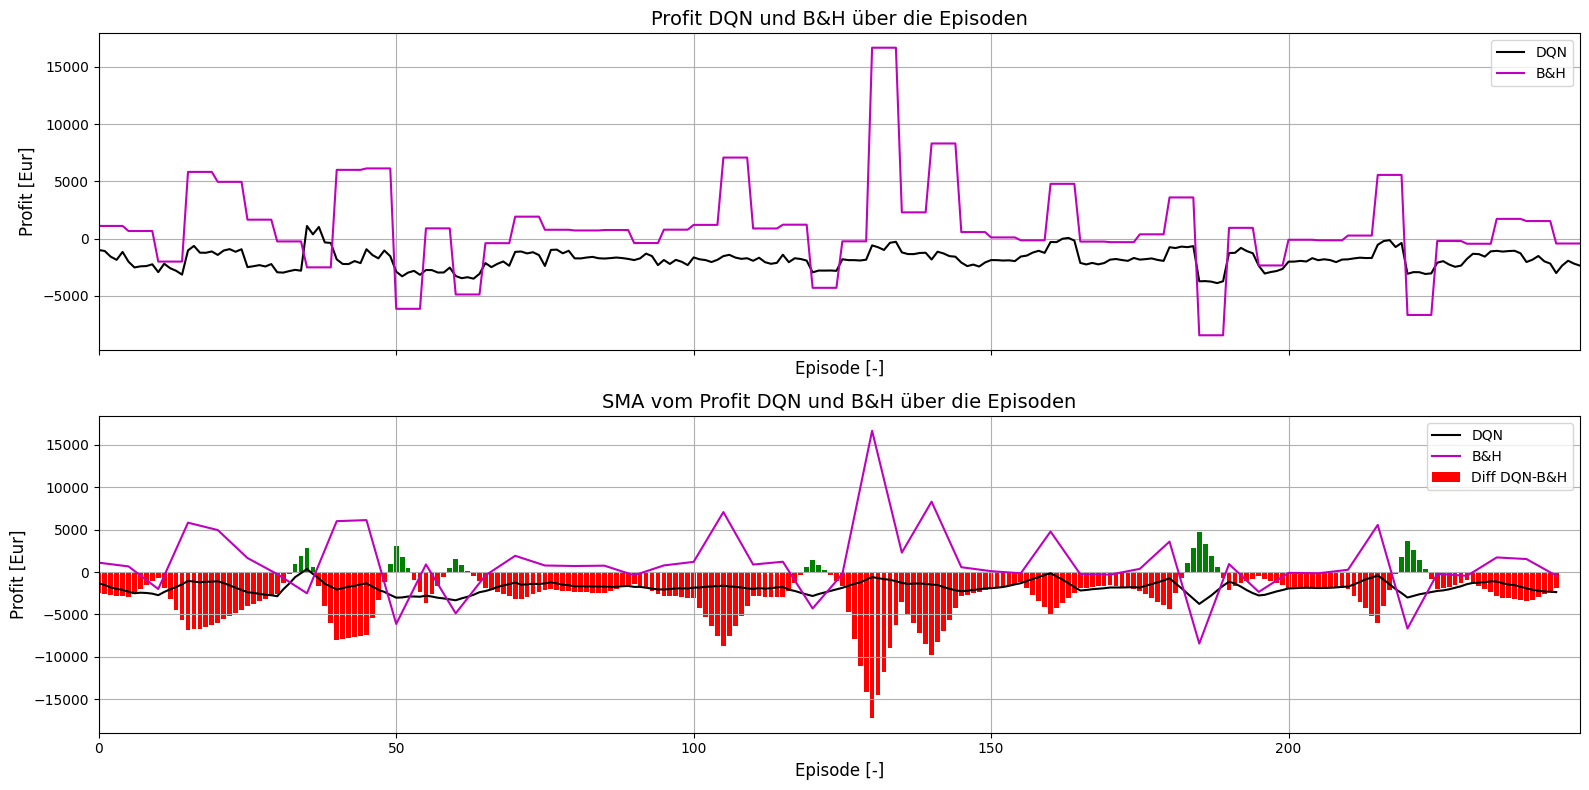

DRL
np.mean(profit), np.std(profit), np.max(profit), np.min(profit),, letzte(profit)
DRL & -382.19 & 496.74 & 1142.99 & -1598.23 & -1147.68 
np.mean(delta_btc_price), np.std(delta_btc_price), np.max(delta_btc_price), np.min(delta_btc_price), letzte(delta_btc_price)
B&H & 48.8 & 5706.87 & 15392.96 & -16391.94 & -6374.69 
DRL
(246,)


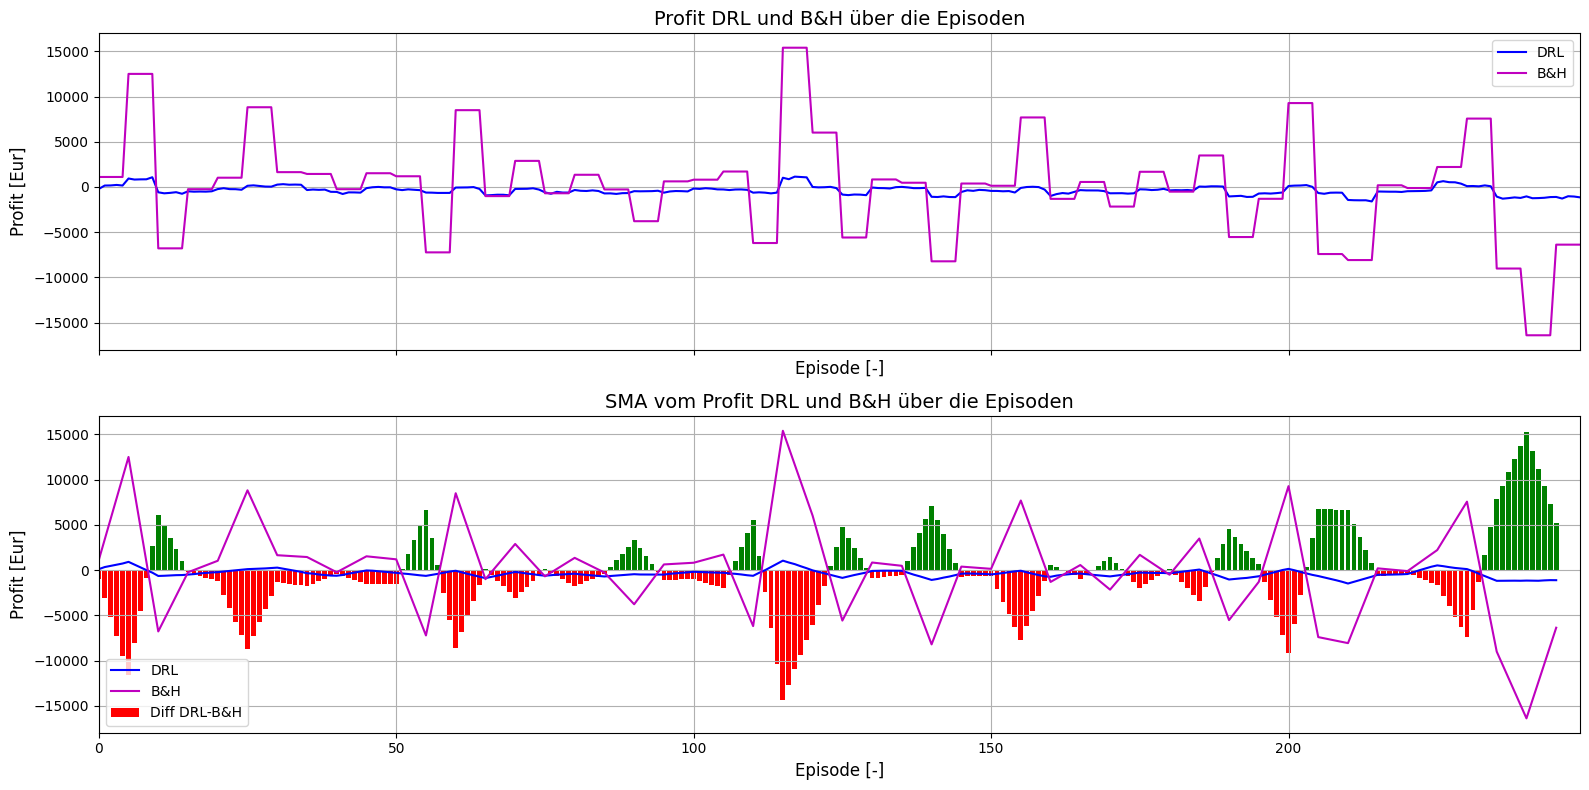

In [88]:
plot_overviews(episode_dqn, profit_dqn, delta_btc_price_dqn, n_conv = n_convs,  algo='DQN', save_name=reward)
plot_overviews(episode_drl, profit_drl, delta_btc_price_drl, n_conv = n_convs,  algo='DRL', save_name=reward)

profit_diff = profit_DRL -   profit_DQN
np.mean(profit dqn), np.std(profit dqn ), np.mean(profit drl), np.std(profit drl)
-1821.6238799999999 822.3422755197167 -382.18520000000007 496.7437141296908
(246,)


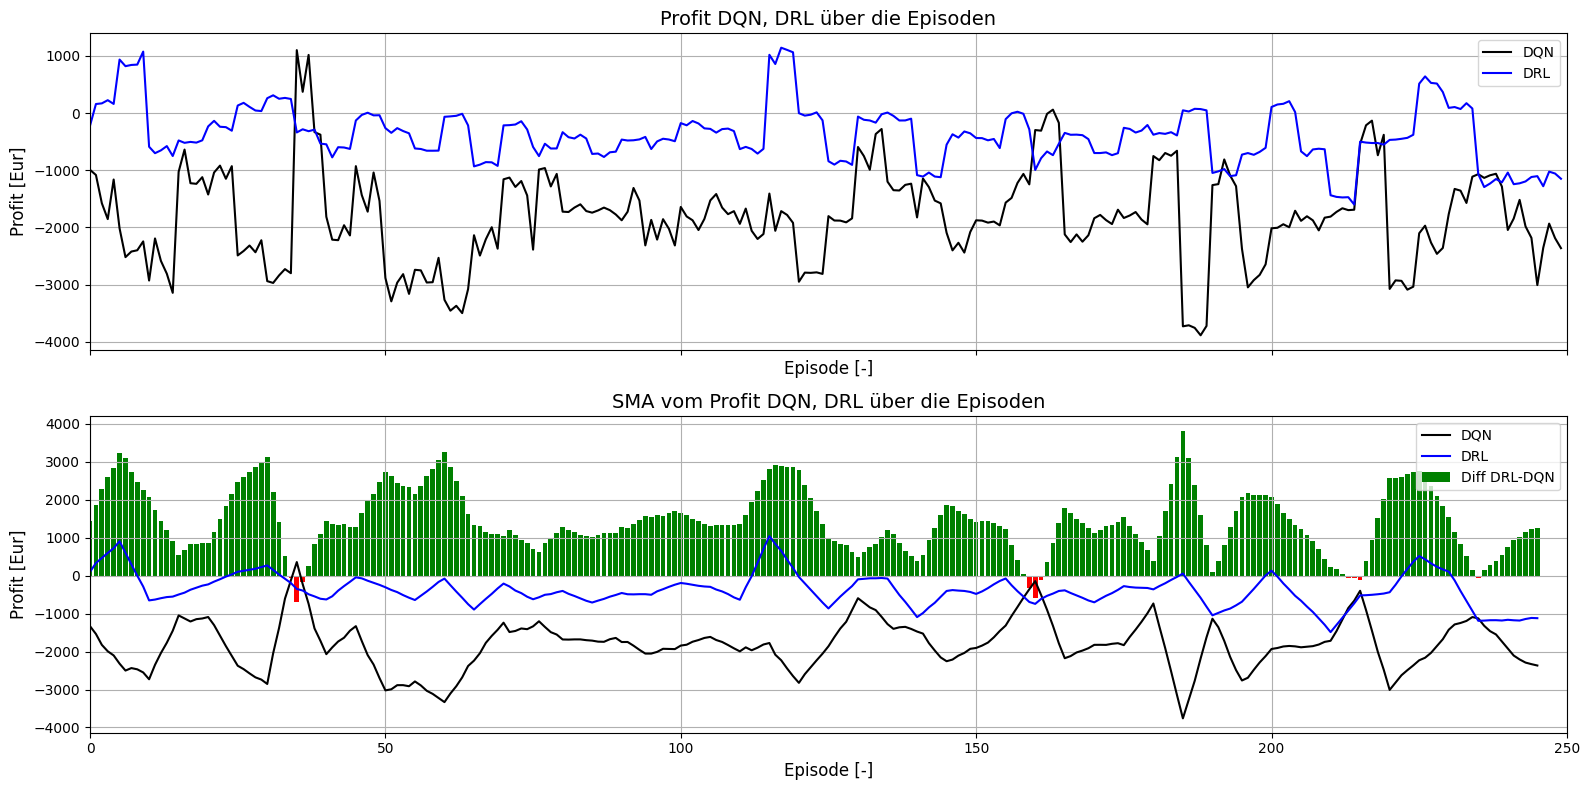

In [89]:
plot_comparison_dqn_drl(episode_dqn, profit_dqn, profit_drl, delta_btc_price_drl, n_conv = n_convs, save_name=reward)

C:\Users\romy_\AppData\Local\Temp\ipykernel_5356\3985346449.py:32: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = [np.fromstring(x[1:-1], dtype=np.float, sep=' ') for x  in dataframe.action[ep*670:(ep+1)*670]]


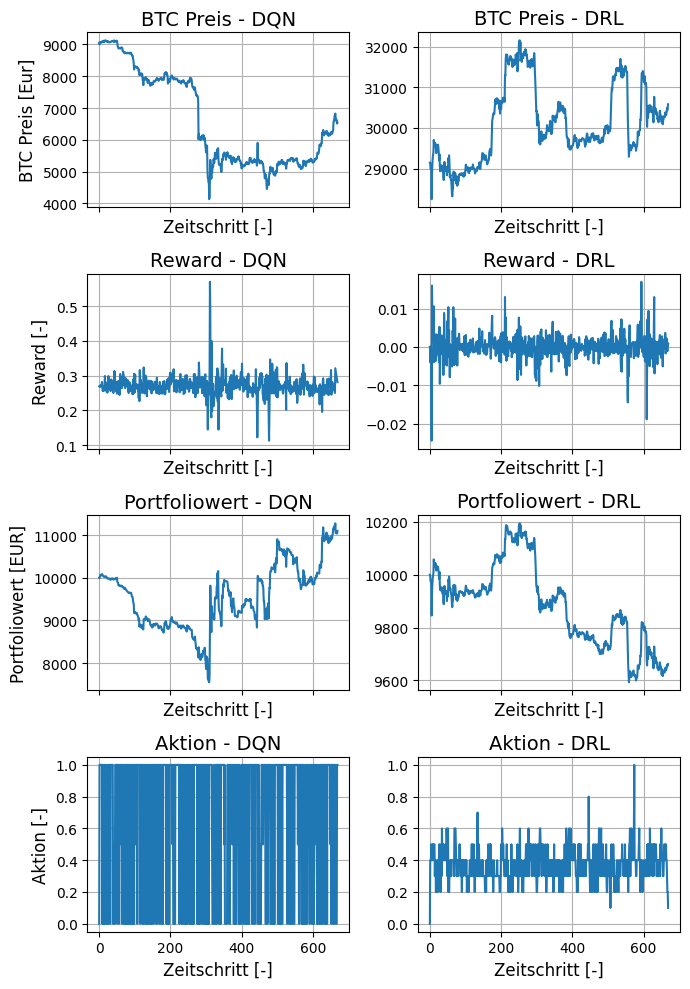

In [90]:
ep=240
plot_episode_info(ep_frame_dqn, ep_frame_drl, ep, save_name=reward)

## Data Analysis: "reward_differential_sharpe_ratio" 

In [91]:
data_folder = os.path.join(base_folder, '20230423_114422')
train_frame_dqn, ep_frame_dqn = get_train_data(data_folder, algorithm='DQN', trial=0, return_df=True)
print('DQN Frames shape: train, ep')
print(train_frame_dqn.shape, ep_frame_dqn.shape)

data_folder = os.path.join(base_folder, '20230424_070731')
train_frame_drl, ep_frame_drl = get_train_data(data_folder, algorithm='DRL', trial=0, return_df=True)
print('DRL Frames shape: train, ep')
print(train_frame_drl.shape, ep_frame_drl.shape)

{'action_domain': [0.0, 1.0],
 'action_space': 4,
 'algorithm': 'DQN_trial_0',
 'asset': 'BTC',
 'batch_size': 16,
 'data_source': 'BTC_histData_dt1800.0s_20220825_0629',
 'episodes': 50,
 'epoch': 2,
 'epsilon': 0.5,
 'epsilon_decay': 0.75,
 'epsilon_final': 0.01,
 'fee': 0.001,
 'from_checkpoint': None,
 'gamma': 0.95,
 'learning_rate': 1e-07,
 'loss_method': 'stantard_loss',
 'money': 10000,
 'obs_space': [8, 20],
 'reward_function': 'reward_differential_sharpe_ratio',
 'runs_p_eps': 5,
 'trainer': 'DQNTrainer'}
DQN Frames shape: train, ep
(167250, 9) (167500, 23)
{'action_domain': [0.0, 1.0],
 'action_space': 1,
 'algorithm': 'DRL_trial_0',
 'asset': 'BTC',
 'batch_size': 16,
 'data_source': 'BTC_histData_dt1800.0s_20220825_0629',
 'episodes': 50,
 'epoch': 2,
 'epsilon': 0.5,
 'epsilon_decay': 0.75,
 'epsilon_final': 0.01,
 'fee': 0.001,
 'from_checkpoint': None,
 'gamma': 0.95,
 'learning_rate': 1e-07,
 'loss_method': 'stantard_loss',
 'money': 10000,
 'obs_space': [8, 20],
 'rew

In [92]:
episode_dqn, profit_dqn, delta_btc_price_dqn = get_profits_every_episode(ep_frame_dqn)
profit_diff_dqn = [profit_dqn[i] - delta_btc_price_dqn[i] for i in range(len(episode_dqn))]

episode_drl, profit_drl, delta_btc_price_drl = get_profits_every_episode(ep_frame_drl)
profit_diff_drl = [profit_drl[i] - delta_btc_price_drl[i] for i in range(len(episode_drl))]
print(f'DRL len: {len(episode_drl)}; DQN len: {len(episode_dqn)}')

DRL len: 238; DQN len: 250


In [93]:
ep_frame_dqn["reward"] = clean_dqn_reward(ep_frame_dqn)

ep_frame_drl["reward"] = np.array([np.fromstring(x[1:-1], dtype=np.float, sep=' ')[0] for x  in ep_frame_drl.reward])

C:\Users\romy_\AppData\Local\Temp\ipykernel_5356\400354885.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ep_re = np.array([np.fromstring(x[1:-1], dtype=np.float, sep=' ')[0] for x  in df.reward])
C:\Users\romy_\AppData\Local\Temp\ipykernel_5356\1478186027.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ep_frame_drl["reward"] = n

In [94]:
n_convs = 5
reward='reward_differential_sharpe_ratio'

In [95]:
dict_reward_plots[reward]=dict()
dict_reward_plots[reward]['profit']=dict()
dict_reward_plots[reward]['rewards']=dict()
dict_reward_plots[reward]['action']=dict()
dict_reward_plots[reward]['btc_price']=dict()
dict_reward_plots[reward]['wallet_value']=dict()
dict_reward_plots[reward]['profit']['dqn']=profit_dqn
dict_reward_plots[reward]['profit']['drl']=profit_drl
dict_reward_plots[reward]['rewards']['dqn']=ep_frame_dqn['reward']
dict_reward_plots[reward]['rewards']['drl']=ep_frame_drl['reward']
dict_reward_plots[reward]['action']['dqn']=ep_frame_dqn['action']
dict_reward_plots[reward]['action']['drl']=ep_frame_drl['action']
dict_reward_plots[reward]['wallet_value']['dqn']=ep_frame_dqn['wallet_value']
dict_reward_plots[reward]['wallet_value']['drl']=ep_frame_drl['wallet_value']
dict_reward_plots[reward]['btc_price']['dqn']=ep_frame_dqn['btc_price']
dict_reward_plots[reward]['btc_price']['drl']=ep_frame_drl['btc_price']
# reward = None

DQN
np.mean(profit), np.std(profit), np.max(profit), np.min(profit),, letzte(profit)
DQN & -1831.35 & 812.9 & 1115.58 & -3719.34 & -2439.76 
np.mean(delta_btc_price), np.std(delta_btc_price), np.max(delta_btc_price), np.min(delta_btc_price), letzte(delta_btc_price)
B&H & 972.84 & 3967.67 & 16663.41 & -8437.78 & -427.38 
DQN
(246,)


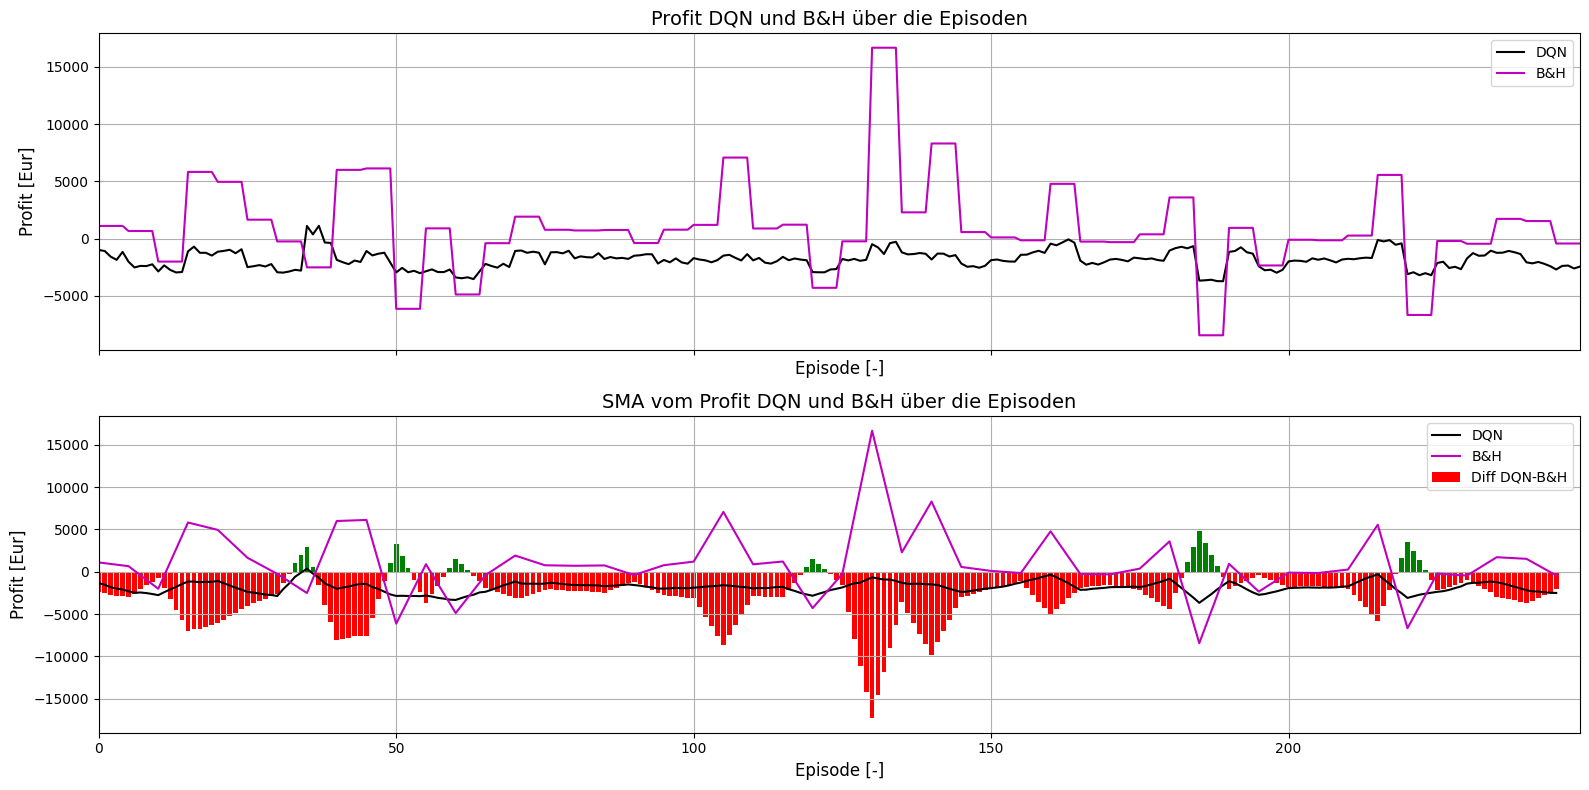

DRL
np.mean(profit), np.std(profit), np.max(profit), np.min(profit),, letzte(profit)
DRL & -325.17 & 787.21 & 2330.98 & -2058.19 & -1878.88 
np.mean(delta_btc_price), np.std(delta_btc_price), np.max(delta_btc_price), np.min(delta_btc_price), letzte(delta_btc_price)
B&H & 605.3 & 5163.83 & 15392.96 & -9014.17 & -9014.17 
DRL
(234,)


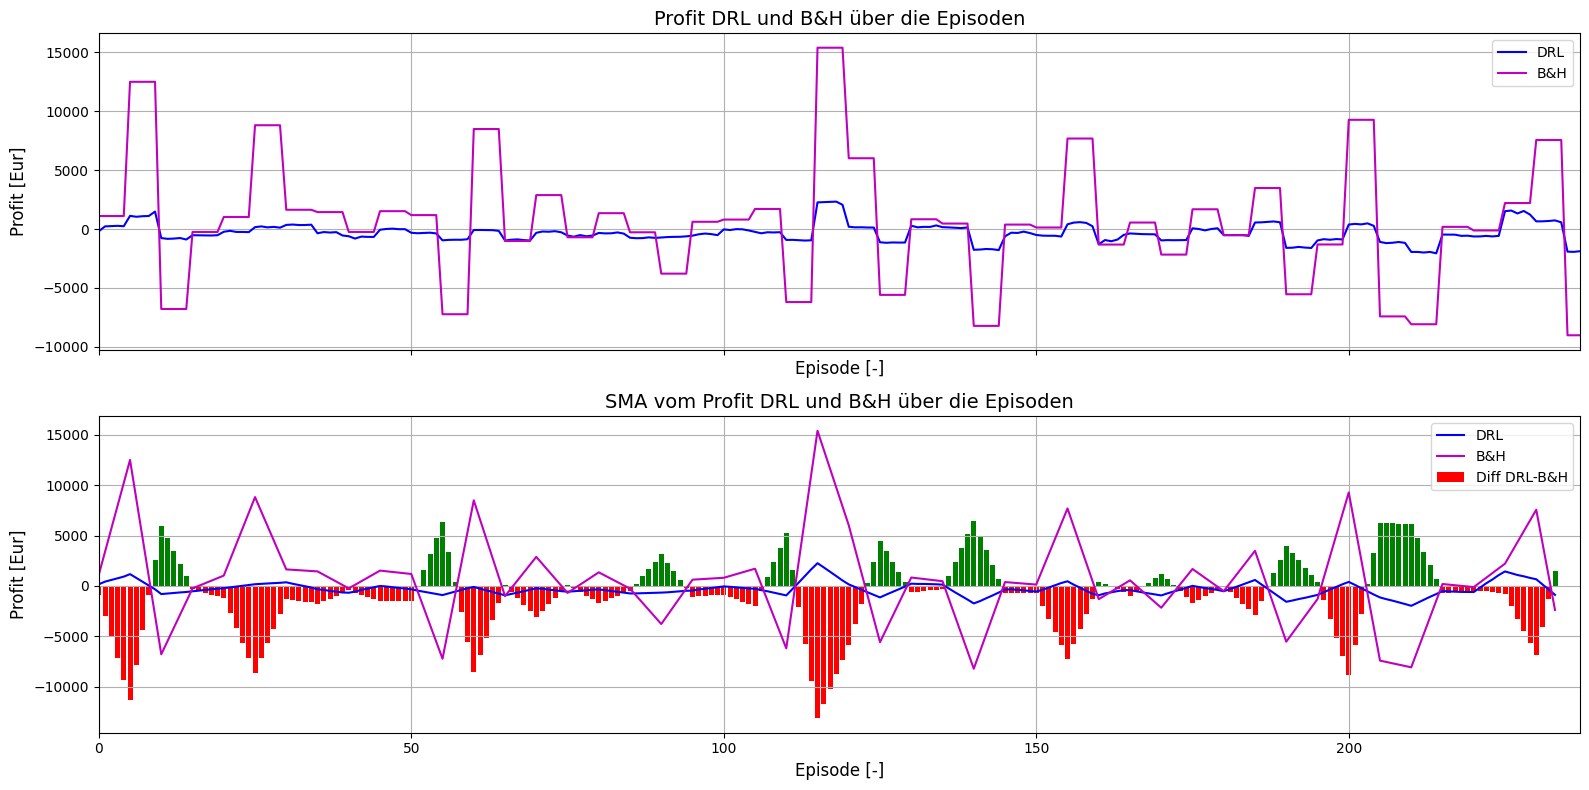

In [96]:
plot_overviews(episode_dqn, profit_dqn, delta_btc_price_dqn, n_conv = n_convs,  algo='DQN', save_name=reward)
plot_overviews(episode_drl, profit_drl, delta_btc_price_drl, n_conv = n_convs,  algo='DRL', save_name=reward)

profit_diff = profit_DRL -   profit_DQN
np.mean(profit dqn), np.std(profit dqn ), np.mean(profit drl), np.std(profit drl)
-1831.34924 812.9043583840737 -325.1720168067227 787.2133395842972
(234,)


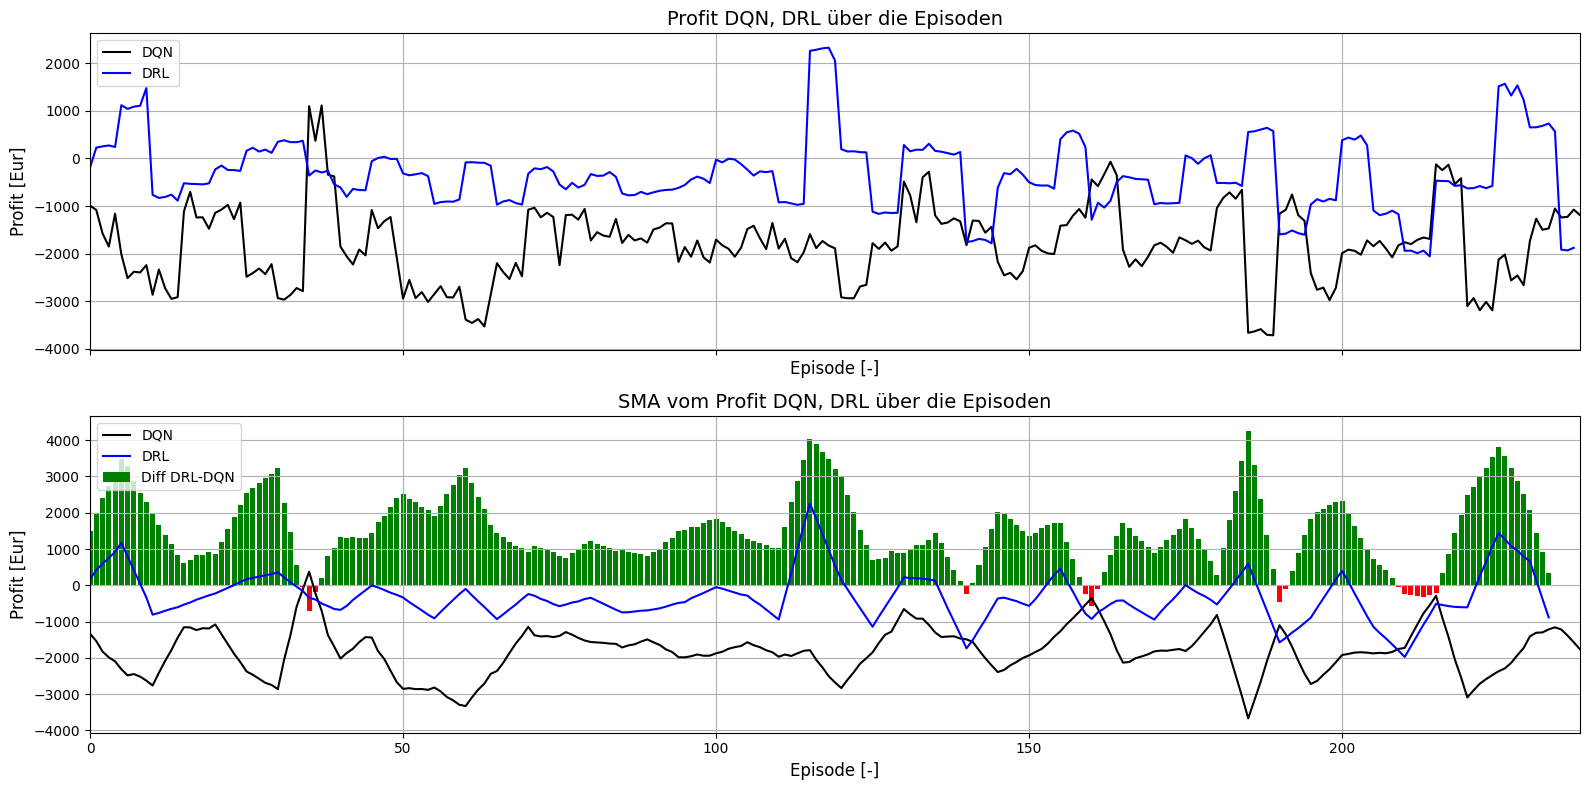

In [97]:
plot_comparison_dqn_drl(episode_drl, profit_dqn, profit_drl, delta_btc_price_drl, n_conv = n_convs, save_name=reward)

C:\Users\romy_\AppData\Local\Temp\ipykernel_5356\3985346449.py:32: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = [np.fromstring(x[1:-1], dtype=np.float, sep=' ') for x  in dataframe.action[ep*670:(ep+1)*670]]


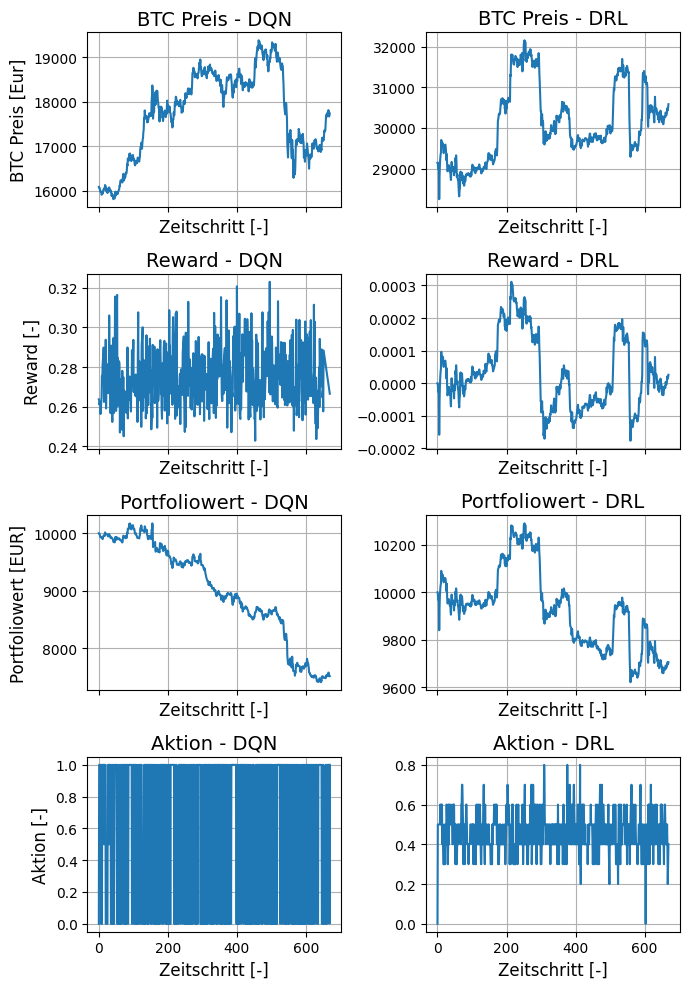

In [98]:
ep=230
plot_episode_info(ep_frame_dqn, ep_frame_drl, ep, save_name=reward)

## Data Analysis: "compute_reward_from_tutor"

In [99]:
data_folder = os.path.join(base_folder, '20230421_181519')
train_frame_dqn, ep_frame_dqn = get_train_data(data_folder, algorithm='DQN', trial=0, return_df=True)
print('DQN Frames shape: train, ep')
print(train_frame_dqn.shape, ep_frame_dqn.shape)

data_folder = os.path.join(base_folder, '20230429_200559')
train_frame_drl, ep_frame_drl = get_train_data(data_folder, algorithm='DRL', trial=0, return_df=True)
print('DRL Frames shape: train, ep')
print(train_frame_drl.shape, ep_frame_drl.shape)

{'action_domain': [0.0, 1.0],
 'action_space': 4,
 'algorithm': 'DQN_trial_0',
 'asset': 'BTC',
 'batch_size': 16,
 'data_source': 'BTC_histData_dt1800.0s_20220825_0629',
 'episodes': 50,
 'epoch': 2,
 'epsilon': 0.5,
 'epsilon_decay': 0.75,
 'epsilon_final': 0.01,
 'fee': 0.001,
 'from_checkpoint': None,
 'gamma': 0.95,
 'learning_rate': 0.001,
 'loss_method': 'stantard_loss',
 'money': 10000,
 'obs_space': [8, 20],
 'reward_function': 'compute_reward_from_tutor',
 'runs_p_eps': 5,
 'trainer': 'DQNTrainer'}
DQN Frames shape: train, ep
(167250, 9) (167500, 23)
{'action_domain': [0.0, 1.0],
 'action_space': 1,
 'algorithm': 'DRL_trial_0',
 'asset': 'BTC',
 'batch_size': 16,
 'data_source': 'BTC_histData_dt1800.0s_20220825_0629',
 'episodes': 50,
 'epoch': 2,
 'epsilon': 0.5,
 'epsilon_decay': 0.75,
 'epsilon_final': 0.01,
 'fee': 0.001,
 'from_checkpoint': None,
 'gamma': 0.95,
 'learning_rate': 1e-06,
 'loss_method': 'stantard_loss',
 'money': 10000,
 'obs_space': [8, 20],
 'reward_fun

In [100]:
episode_dqn, profit_dqn, delta_btc_price_dqn = get_profits_every_episode(ep_frame_dqn)
profit_diff_dqn = [profit_dqn[i] - delta_btc_price_dqn[i] for i in range(len(episode_dqn))]

episode_drl, profit_drl, delta_btc_price_drl = get_profits_every_episode(ep_frame_drl)
profit_diff_drl = [profit_drl[i] - delta_btc_price_drl[i] for i in range(len(episode_drl))]
print(f'DRL len: {len(episode_drl)}; DQN len: {len(episode_dqn)}')

DRL len: 250; DQN len: 250


In [101]:
ep_frame_dqn["reward"] = clean_dqn_reward(ep_frame_dqn)

ep_frame_drl["reward"] = np.array([np.fromstring(x[1:-1], dtype=np.float, sep=' ')[0] for x  in ep_frame_drl.reward])

C:\Users\romy_\AppData\Local\Temp\ipykernel_5356\400354885.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ep_re = np.array([np.fromstring(x[1:-1], dtype=np.float, sep=' ')[0] for x  in df.reward])
C:\Users\romy_\AppData\Local\Temp\ipykernel_5356\1478186027.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ep_frame_drl["reward"] = n

In [102]:
n_convs = 5
reward='compute_reward_from_tutor'

In [103]:
dict_reward_plots[reward]=dict()
dict_reward_plots[reward]['profit']=dict()
dict_reward_plots[reward]['rewards']=dict()
dict_reward_plots[reward]['action']=dict()
dict_reward_plots[reward]['btc_price']=dict()
dict_reward_plots[reward]['wallet_value']=dict()
dict_reward_plots[reward]['profit']['dqn']=profit_dqn
dict_reward_plots[reward]['profit']['drl']=profit_drl
dict_reward_plots[reward]['rewards']['dqn']=ep_frame_dqn['reward']
dict_reward_plots[reward]['rewards']['drl']=ep_frame_drl['reward']
dict_reward_plots[reward]['action']['dqn']=ep_frame_dqn['action']
dict_reward_plots[reward]['action']['drl']=ep_frame_drl['action']
dict_reward_plots[reward]['wallet_value']['dqn']=ep_frame_dqn['wallet_value']
dict_reward_plots[reward]['wallet_value']['drl']=ep_frame_drl['wallet_value']
dict_reward_plots[reward]['btc_price']['dqn']=ep_frame_dqn['btc_price']
dict_reward_plots[reward]['btc_price']['drl']=ep_frame_drl['btc_price']
# reward = None

DQN
np.mean(profit), np.std(profit), np.max(profit), np.min(profit),, letzte(profit)
DQN & 3.78 & 552.86 & 2657.2 & -2761.93 & -206.5 
np.mean(delta_btc_price), np.std(delta_btc_price), np.max(delta_btc_price), np.min(delta_btc_price), letzte(delta_btc_price)
B&H & 972.84 & 3967.67 & 16663.41 & -8437.78 & -427.38 
DQN
(246,)


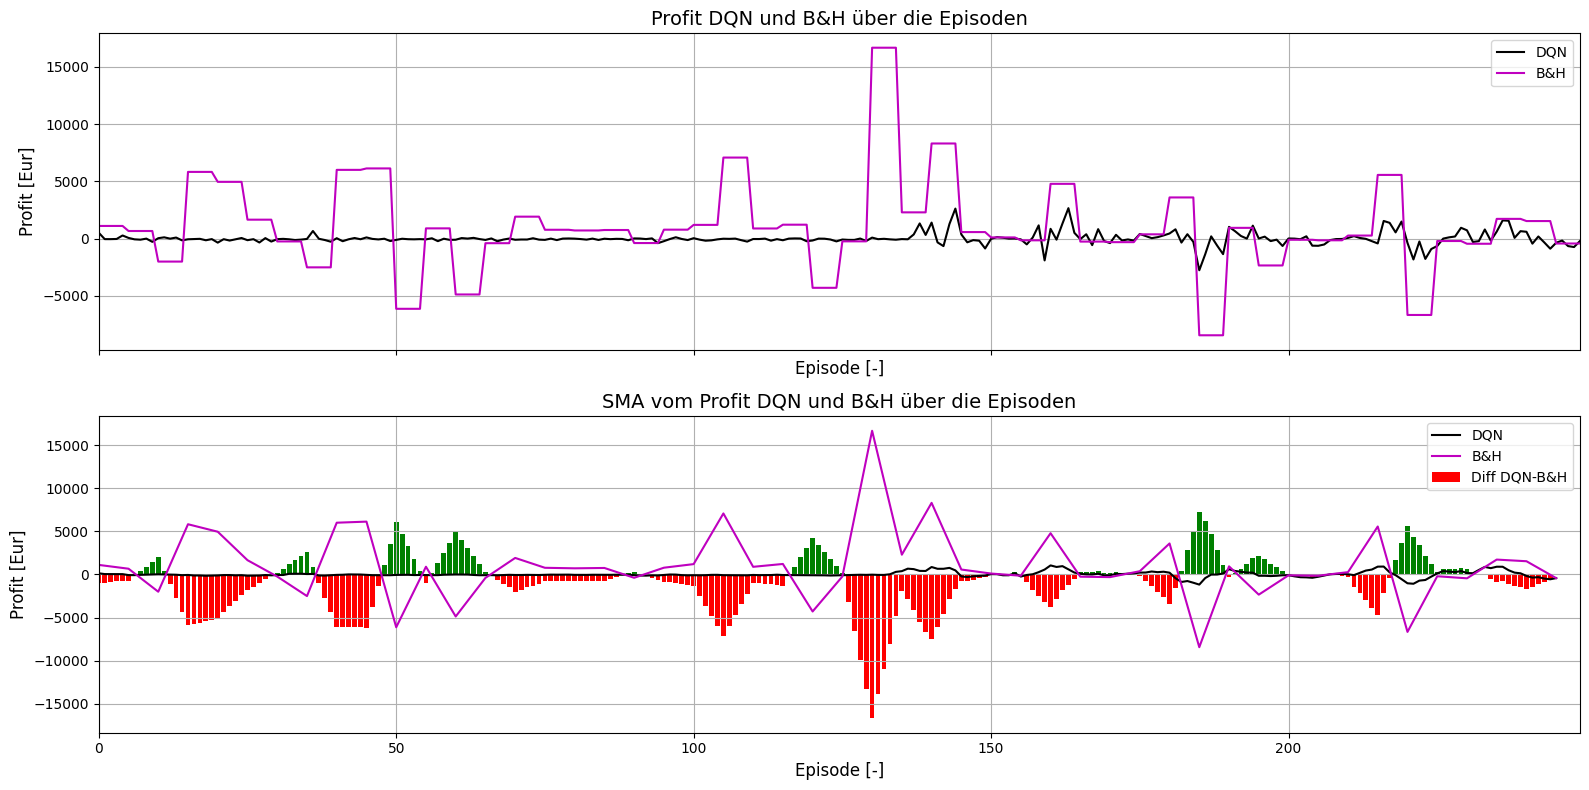

DRL
np.mean(profit), np.std(profit), np.max(profit), np.min(profit),, letzte(profit)
DRL & 48.63 & 1069.22 & 4917.87 & -2034.71 & -348.9 
np.mean(delta_btc_price), np.std(delta_btc_price), np.max(delta_btc_price), np.min(delta_btc_price), letzte(delta_btc_price)
B&H & 48.8 & 5706.87 & 15392.96 & -16391.94 & -6374.69 
DRL
(246,)


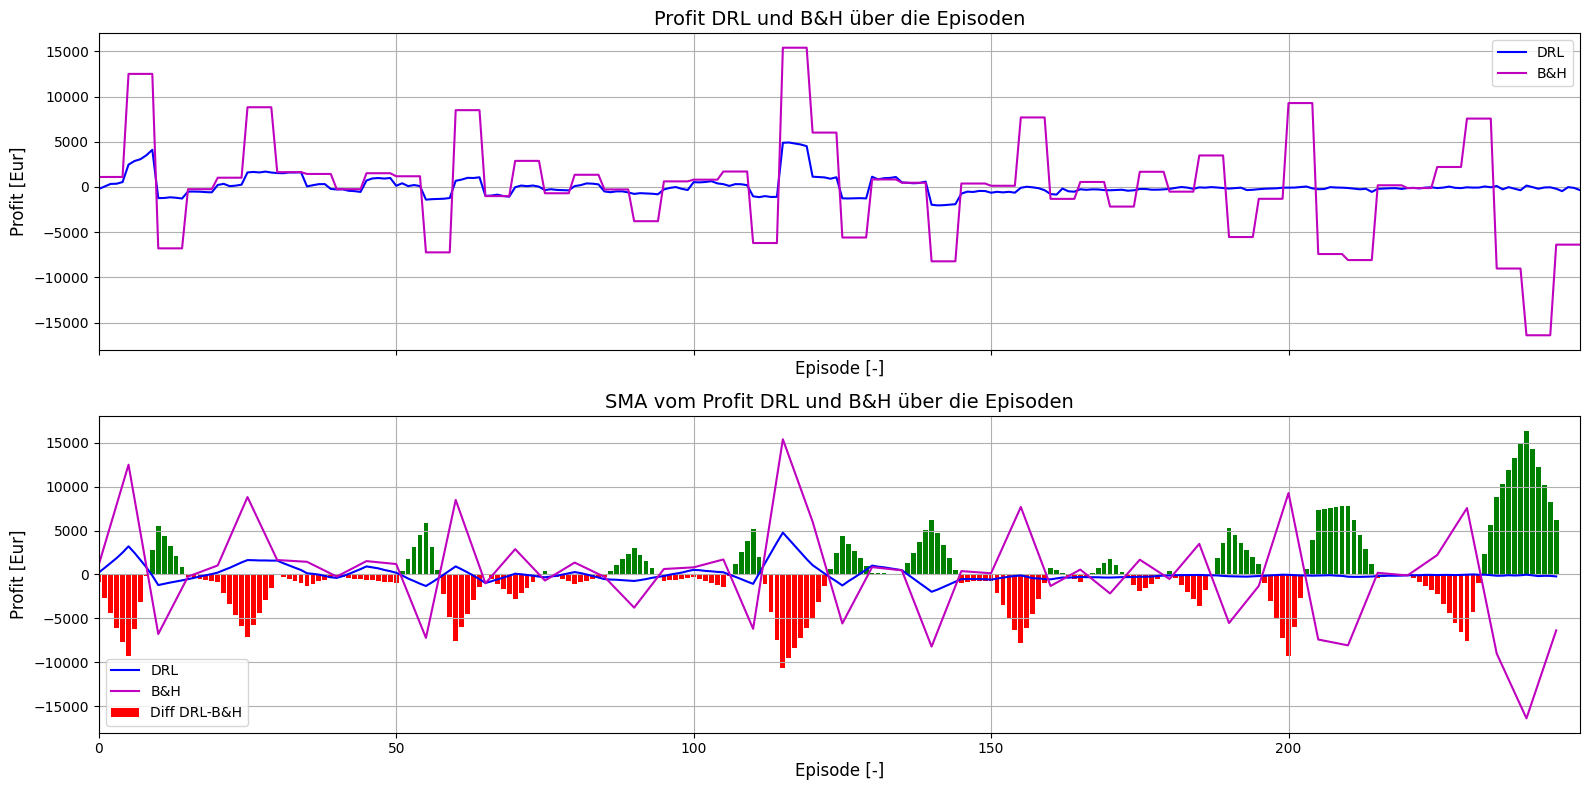

In [104]:
plot_overviews(episode_dqn, profit_dqn, delta_btc_price_dqn, n_conv = n_convs,  algo='DQN', save_name=reward)
plot_overviews(episode_drl, profit_drl, delta_btc_price_drl, n_conv = n_convs,  algo='DRL', save_name=reward)

profit_diff = profit_DRL -   profit_DQN
np.mean(profit dqn), np.std(profit dqn ), np.mean(profit drl), np.std(profit drl)
3.779599999999973 552.8615078515054 48.634679999999996 1069.2197821488796
(246,)


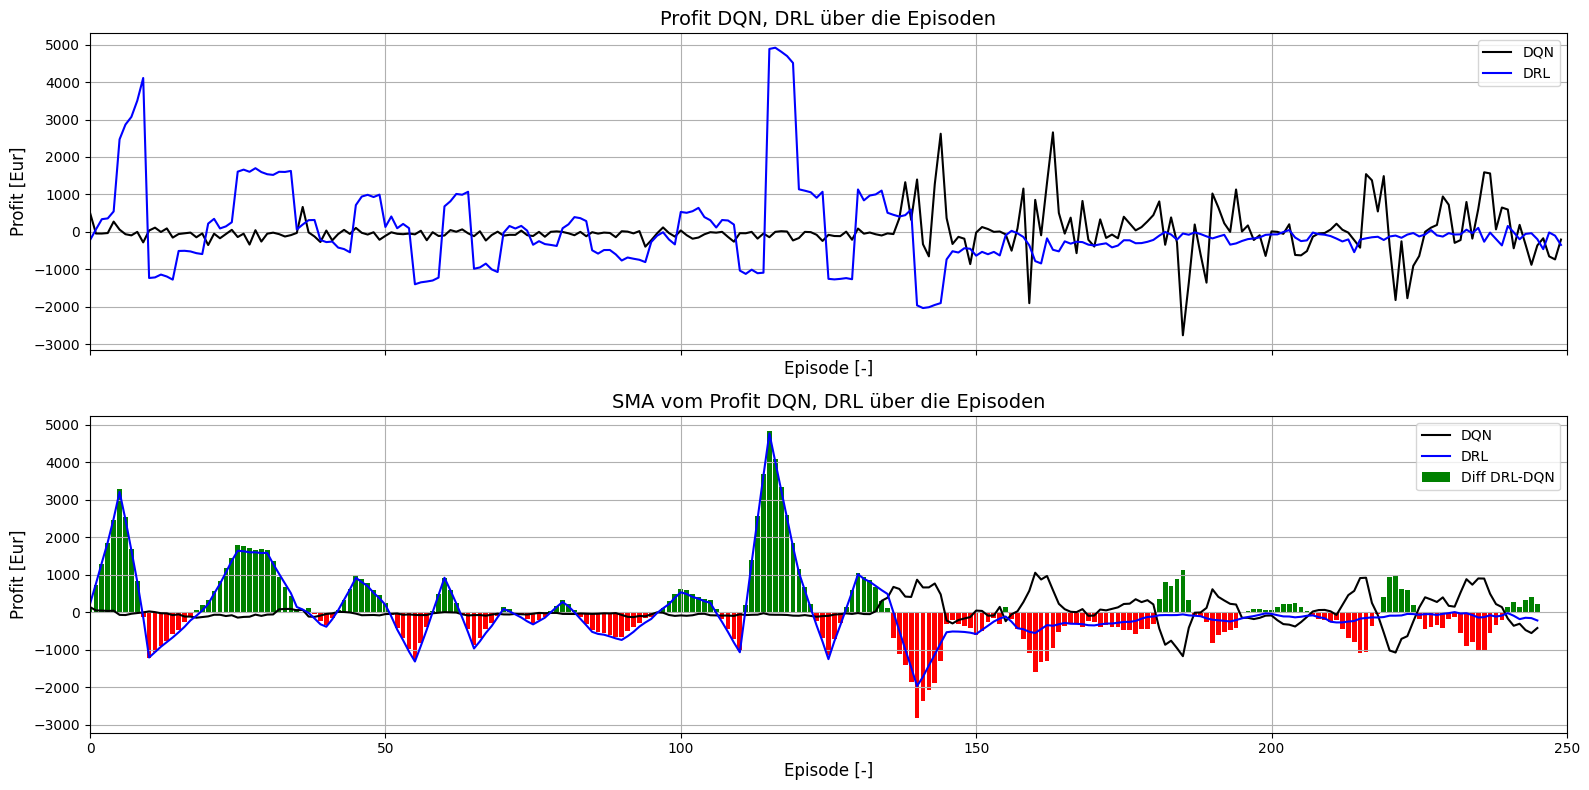

In [105]:
plot_comparison_dqn_drl(episode_dqn, profit_dqn, profit_drl, delta_btc_price_drl, n_conv = n_convs, save_name=reward)

C:\Users\romy_\AppData\Local\Temp\ipykernel_5356\3985346449.py:32: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = [np.fromstring(x[1:-1], dtype=np.float, sep=' ') for x  in dataframe.action[ep*670:(ep+1)*670]]


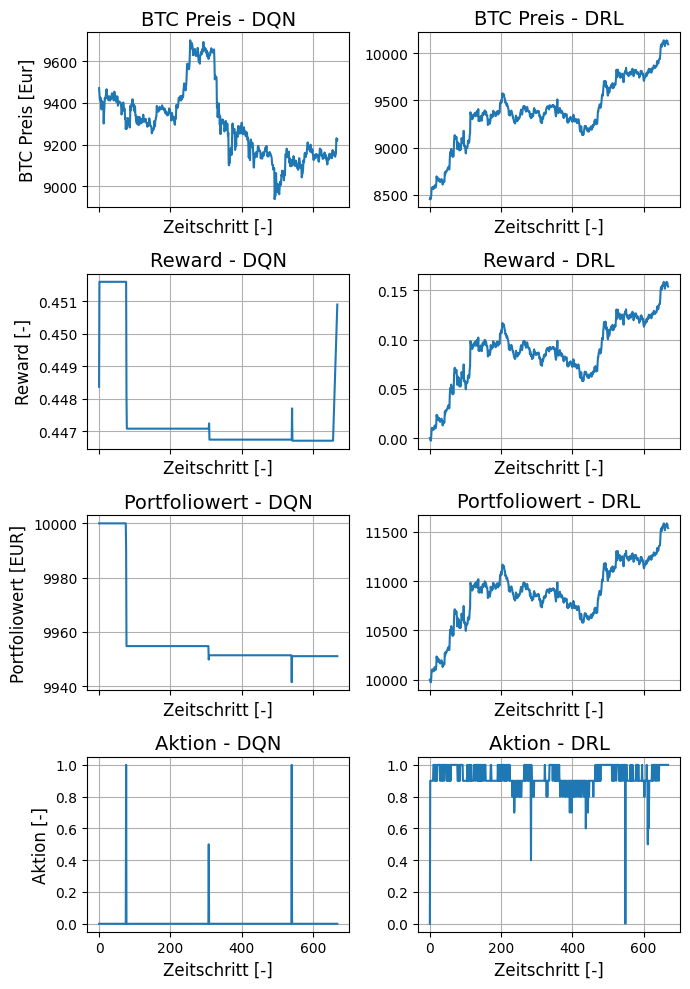

In [106]:
ep=235
plot_episode_info(ep_frame_dqn, ep_frame_drl, ep, save_name=reward)

## Data Analysis: "reward_profit"

In [107]:
data_folder = os.path.join(base_folder, '20230423_231505')
train_frame_dqn, ep_frame_dqn = get_train_data(data_folder, algorithm='DQN', trial=0, return_df=True)
print('DQN Frames shape: train, ep')
print(train_frame_dqn.shape, ep_frame_dqn.shape)

data_folder = os.path.join(base_folder, '20230420_083508')
train_frame_drl, ep_frame_drl = get_train_data(data_folder, algorithm='DRL', trial=0, return_df=True)
print('DRL Frames shape: train, ep')
print(train_frame_drl.shape, ep_frame_drl.shape)

{'action_domain': [0.0, 1.0],
 'action_space': 4,
 'algorithm': 'DQN_trial_0',
 'asset': 'BTC',
 'batch_size': 16,
 'data_source': 'BTC_histData_dt1800.0s_20220825_0629',
 'episodes': 50,
 'epoch': 2,
 'epsilon': 0.5,
 'epsilon_decay': 0.75,
 'epsilon_final': 0.01,
 'fee': 0.001,
 'from_checkpoint': None,
 'gamma': 0.95,
 'learning_rate': 1e-05,
 'loss_method': 'stantard_loss',
 'money': 10000,
 'obs_space': [8, 20],
 'reward_function': 'reward_profit',
 'runs_p_eps': 5,
 'trainer': 'DQNTrainer'}
DQN Frames shape: train, ep
(167250, 9) (167500, 23)
{'action_domain': [0.0, 1.0],
 'action_space': 1,
 'algorithm': 'DRL_trial_8',
 'asset': 'BTC',
 'batch_size': 32,
 'data_source': 'BTC_histData_dt1800.0s_20220825_0629',
 'episodes': 50,
 'epoch': 2,
 'epsilon': 0.5,
 'epsilon_decay': 0.75,
 'epsilon_final': 0.01,
 'fee': 0.001,
 'from_checkpoint': None,
 'gamma': 0.95,
 'learning_rate': 1e-05,
 'loss_method': 'stantard_loss',
 'money': 10000,
 'obs_space': [8, 20],
 'reward_function': 'rew

In [108]:
episode_dqn, profit_dqn, delta_btc_price_dqn = get_profits_every_episode(ep_frame_dqn)
profit_diff_dqn = [profit_dqn[i] - delta_btc_price_dqn[i] for i in range(len(episode_dqn))]

episode_drl, profit_drl, delta_btc_price_drl = get_profits_every_episode(ep_frame_drl)
profit_diff_drl = [profit_drl[i] - delta_btc_price_drl[i] for i in range(len(episode_drl))]
print(f'DRL len: {len(episode_drl)}; DQN len: {len(episode_dqn)}')

DRL len: 250; DQN len: 250


In [109]:
ep_frame_dqn["reward"] = clean_dqn_reward(ep_frame_dqn)

ep_frame_drl["reward"] = np.array([np.fromstring(x[1:-1], dtype=np.float, sep=' ')[0] for x  in ep_frame_drl.reward])

C:\Users\romy_\AppData\Local\Temp\ipykernel_5356\400354885.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ep_re = np.array([np.fromstring(x[1:-1], dtype=np.float, sep=' ')[0] for x  in df.reward])
C:\Users\romy_\AppData\Local\Temp\ipykernel_5356\1478186027.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ep_frame_drl["reward"] = n

In [110]:
n_convs = 5
reward='reward_profit'

In [111]:
dict_reward_plots[reward]=dict()
dict_reward_plots[reward]['profit']=dict()
dict_reward_plots[reward]['rewards']=dict()
dict_reward_plots[reward]['action']=dict()
dict_reward_plots[reward]['btc_price']=dict()
dict_reward_plots[reward]['wallet_value']=dict()
dict_reward_plots[reward]['profit']['dqn']=profit_dqn
dict_reward_plots[reward]['profit']['drl']=profit_drl
dict_reward_plots[reward]['rewards']['dqn']=ep_frame_dqn['reward']
dict_reward_plots[reward]['rewards']['drl']=ep_frame_drl['reward']
dict_reward_plots[reward]['action']['dqn']=ep_frame_dqn['action']
dict_reward_plots[reward]['action']['drl']=ep_frame_drl['action']
dict_reward_plots[reward]['wallet_value']['dqn']=ep_frame_dqn['wallet_value']
dict_reward_plots[reward]['wallet_value']['drl']=ep_frame_drl['wallet_value']
dict_reward_plots[reward]['btc_price']['dqn']=ep_frame_dqn['btc_price']
dict_reward_plots[reward]['btc_price']['drl']=ep_frame_drl['btc_price']
# reward = None

DQN
np.mean(profit), np.std(profit), np.max(profit), np.min(profit),, letzte(profit)
DQN & -1256.93 & 823.58 & 1604.01 & -3740.13 & -974.61 
np.mean(delta_btc_price), np.std(delta_btc_price), np.max(delta_btc_price), np.min(delta_btc_price), letzte(delta_btc_price)
B&H & 972.84 & 3967.67 & 16663.41 & -8437.78 & -427.38 
DQN
(246,)


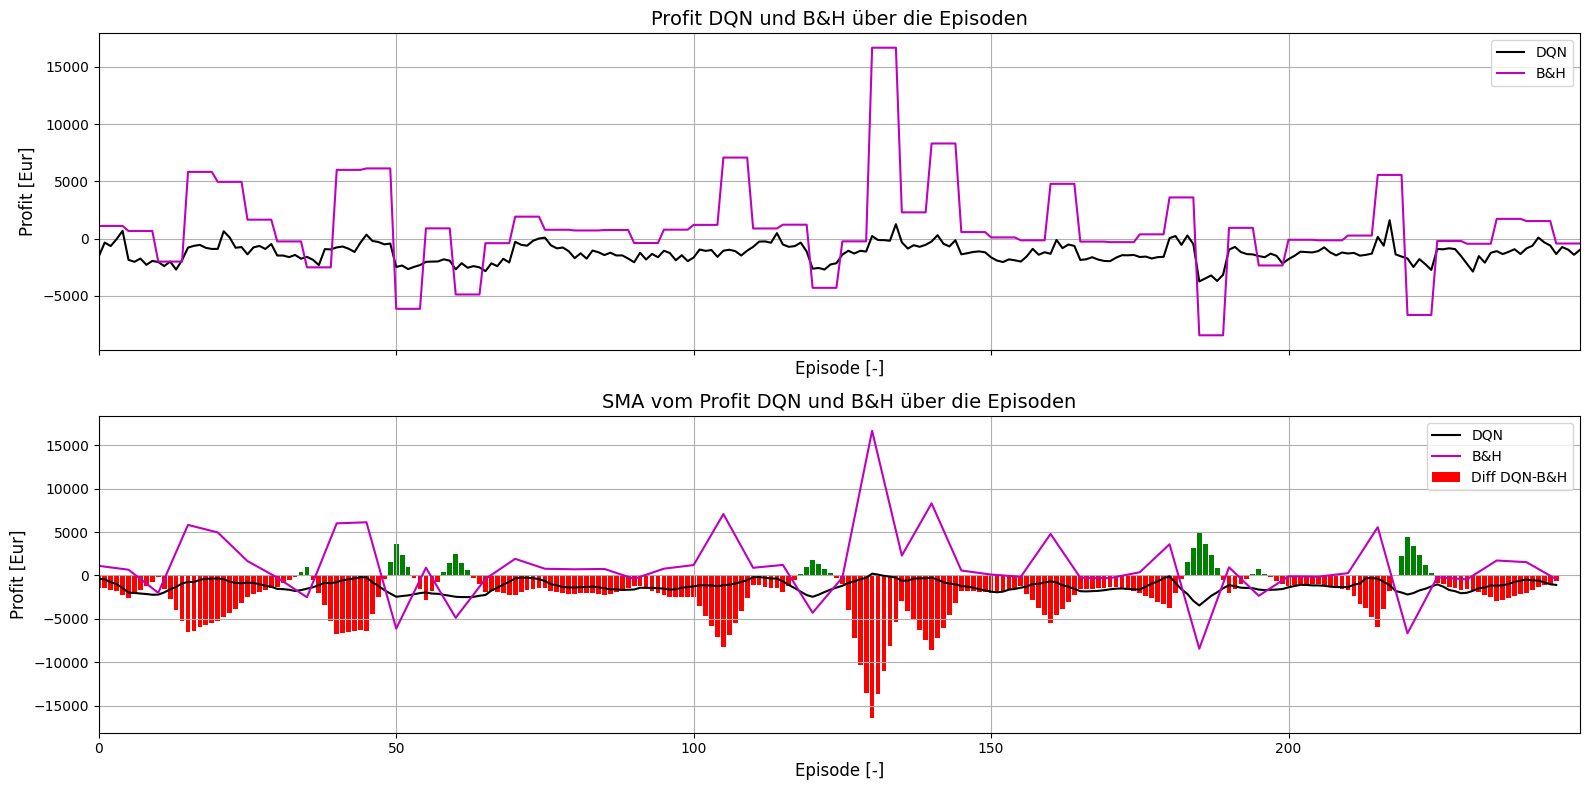

DRL
np.mean(profit), np.std(profit), np.max(profit), np.min(profit),, letzte(profit)
DRL & -272.11 & 1102.43 & 4300.42 & -1971.96 & 289.98 
np.mean(delta_btc_price), np.std(delta_btc_price), np.max(delta_btc_price), np.min(delta_btc_price), letzte(delta_btc_price)
B&H & -32.71 & 5271.41 & 15898.86 & -15765.27 & 556.26 
DRL
(246,)


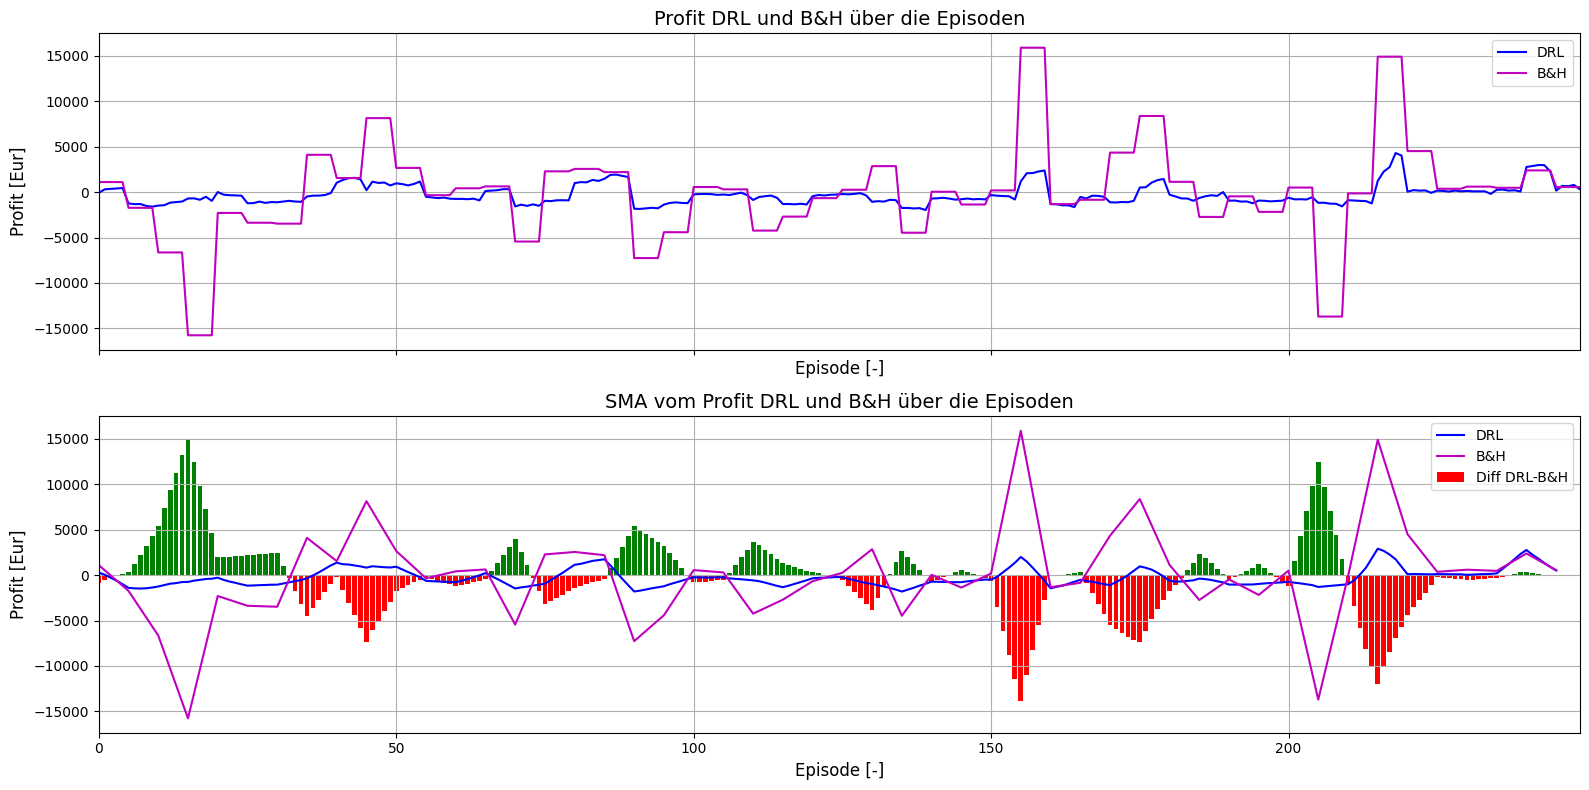

In [112]:
plot_overviews(episode_dqn, profit_dqn, delta_btc_price_dqn, n_conv = n_convs,  algo='DQN', save_name=reward)
plot_overviews(episode_drl, profit_drl, delta_btc_price_drl, n_conv = n_convs,  algo='DRL', save_name=reward)

profit_diff = profit_DRL -   profit_DQN
np.mean(profit dqn), np.std(profit dqn ), np.mean(profit drl), np.std(profit drl)
-1256.93216 823.5810803811208 -272.10812000000004 1102.4263441340947
(246,)


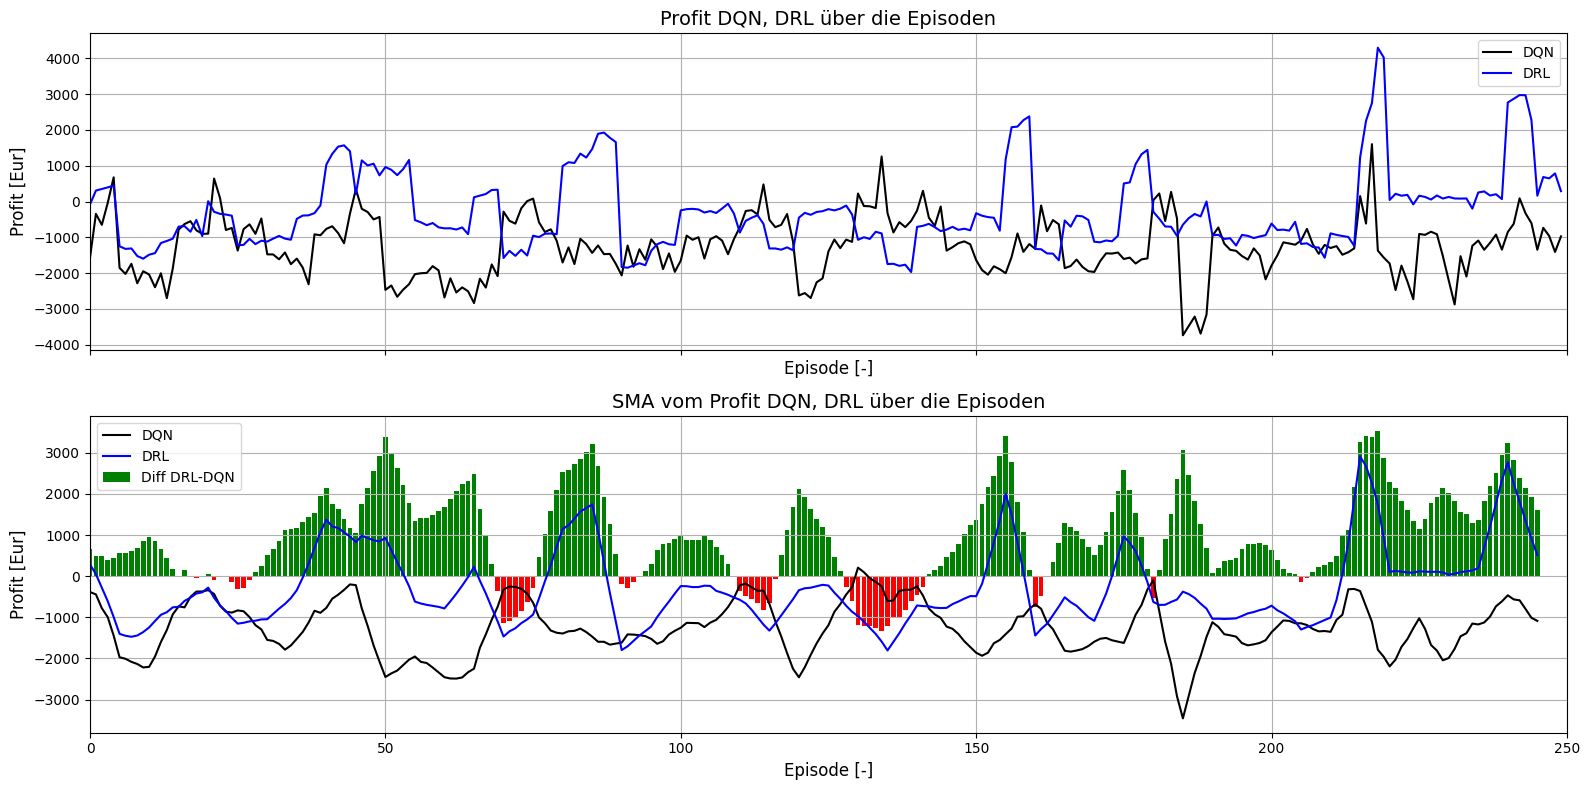

In [113]:
plot_comparison_dqn_drl(episode_dqn, profit_dqn, profit_drl, delta_btc_price_drl, n_conv = n_convs, save_name=reward)

C:\Users\romy_\AppData\Local\Temp\ipykernel_5356\3985346449.py:32: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = [np.fromstring(x[1:-1], dtype=np.float, sep=' ') for x  in dataframe.action[ep*670:(ep+1)*670]]


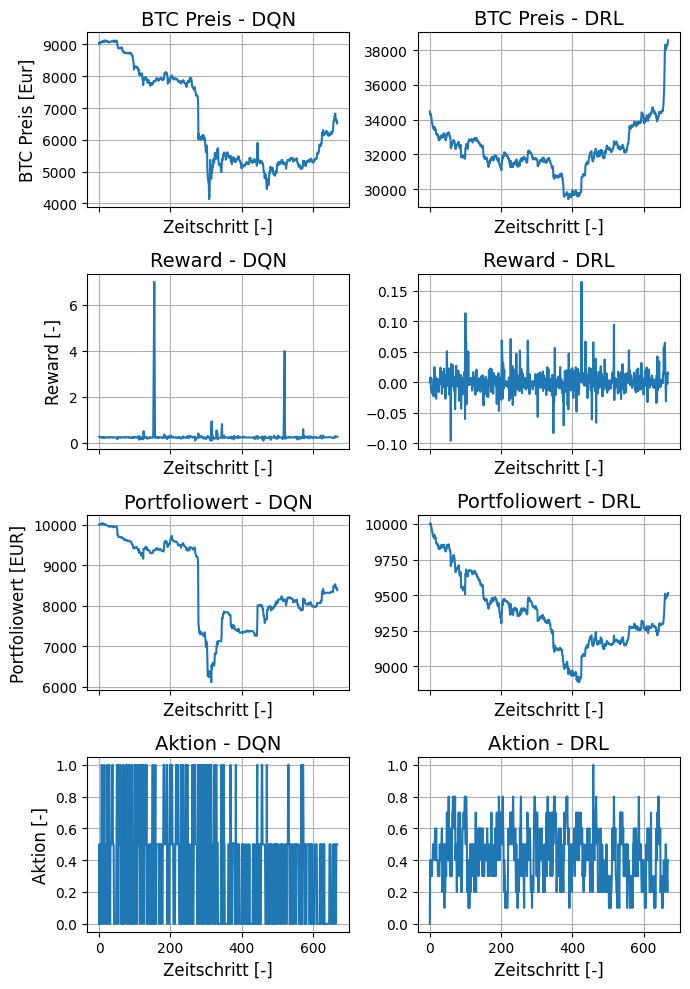

In [114]:
ep=240
plot_episode_info(ep_frame_dqn, ep_frame_drl, ep, save_name=reward)

# Analysis Reward Functions

In [120]:
def plot_compare_rewards(reward_dict, buy_hold_profit, ep, 
                algo='drl', save_name=None):
    reward_list = [ 'reward_differential_sharpe_ratio', 'reward_profit',  'compute_reward_from_tutor',   'reward_sharpe_ratio']
    name_list = {'reward_differential_sharpe_ratio': "Diff. Sharpe Ratio", 
                 'reward_profit' : "Profit",  
                 'compute_reward_from_tutor': "Portfolioswert",   
                 'reward_sharpe_ratio': "Sharpe Ratio",
                 "buy_and_hold": "B&H"}
    # reward_list = ['reward_sharpe_ratio', 'reward_differential_sharpe_ratio']
    color_list = {'reward_profit': 'g',
                  'compute_reward_from_tutor': 'k', 
                  'reward_sharpe_ratio': 'r', 
                  'buy_and_hold': 'b', 
                  'reward_differential_sharpe_ratio':'m'}
    
    # fig, ax = plt.subplots(3,len(reward_list), figsize=(10,10), sharex=False)
    # fig = plt.figure(figsize=(11,8.5))
    fig = plt.figure(figsize=(11,6))
    rows = 2
    cols =len(reward_list)
    # gs = fig.add_gridspec(rows,cols)
    
    # for col, re in enumerate(reward_list):
    #     ax = fig.add_subplot(gs[0, col])
        
    #     # y = [np.fromstring(x[1:-1], dtype=np.float, sep=' ') for x  in reward_dict[re]['rewards'][algo][ep*670:(ep+1)*670]]
    #     y = [x for x in reward_dict[re]['rewards'][algo][ep*670:(ep+1)*670]]
    #     tmp_Str = re.replace('_', ' ').title()
    #     ax.plot(y, color=color_list[re], label=name_list[re])
    #     ax.set_title(f"{name_list[re]}")
    #     if col == 0:
    #         ax.set_ylabel("Reward [-]")
    #     ax.set_xlabel("Zeitschritt [-]")
    #     ax.legend(loc='lower left')
    #     ax.grid()

    # ax = fig.add_subplot(gs[1, :])
    ax = fig.add_subplot(111)
    reward_list.append('buy_and_hold')
    reward_dict['buy_and_hold'] = dict()
    reward_dict['buy_and_hold']['profit'] =dict()
    reward_dict['buy_and_hold']['profit'][algo] = buy_hold_profit
    print(reward_list)
    for re in reward_list:
        y = reward_dict[re]['profit'][algo]
        ax.plot(y, color=color_list[re], label=name_list[re])
        # ax.plot(np.cumsum(y), color=color_list[re], label=re.replace('_', ' ').title())
        
    
    ax.set_title(f"Profit bei Reward über die Episode - {algo.upper()}")
    ax.set_ylabel("Profit [Eur]")
    ax.set_xlabel("Episode [-]")
    ax.grid()
    

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, ncol=len(reward_list), loc='lower left')
    
    plt.tight_layout() 
    
    if save_name is not None:
        plt.savefig(f'../data/plots/rewards_comparison_{ep}_{algo}_{save_name}.pdf', format='pdf', dpi=300)
        # plt.savefig(f'../data/plots/rewards_comparison_{ep}_{algo}_{save_name}.png', format='png', dpi=300)
    plt.show()

In [121]:
SMALL_SIZE = 8
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

['reward_differential_sharpe_ratio', 'reward_profit', 'compute_reward_from_tutor', 'reward_sharpe_ratio', 'buy_and_hold']


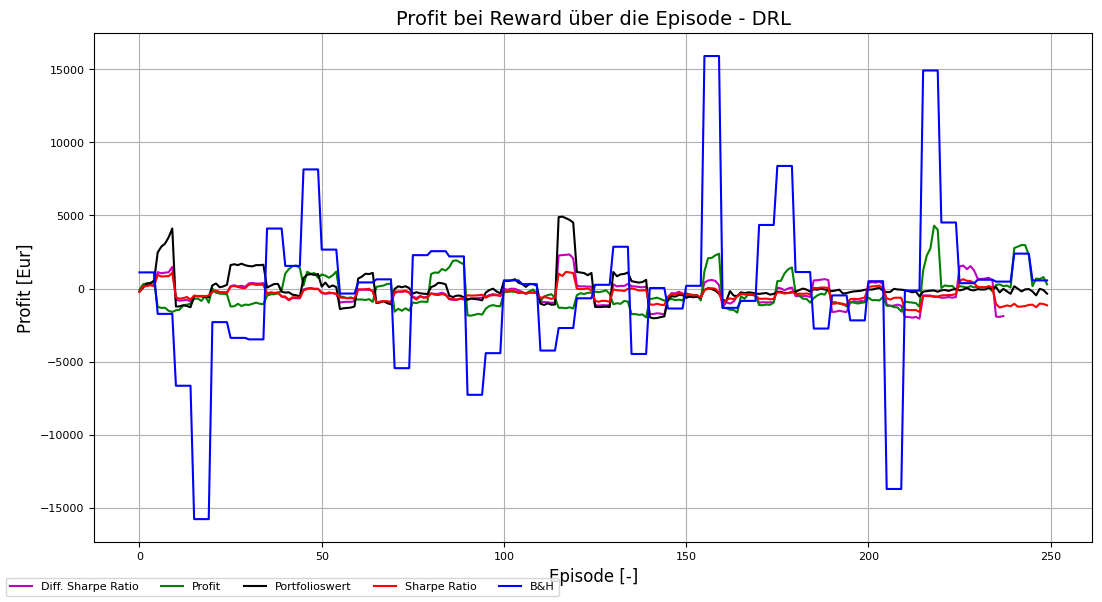

In [122]:
n_ep = 225
plot_compare_rewards(dict_reward_plots, delta_btc_price_drl, n_ep, algo='drl', save_name='rewards_w_btc')

['reward_differential_sharpe_ratio', 'reward_profit', 'compute_reward_from_tutor', 'reward_sharpe_ratio', 'buy_and_hold']


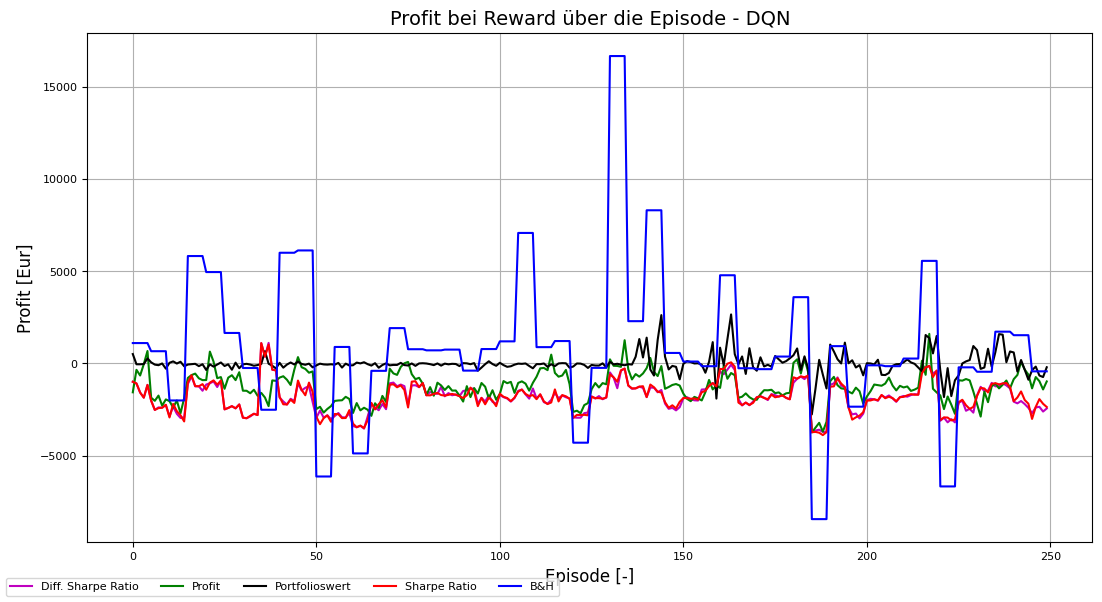

In [123]:
# TODO: plots with rewards for each trainer, add B&H 
# TODO: plot: compare best results for both trainers 
n_ep = 210
plot_compare_rewards(dict_reward_plots, delta_btc_price_dqn, n_ep, algo='dqn', save_name='rewards_w_btc')

profit_diff = profit_DRL -   profit_DQN
np.mean(profit dqn), np.std(profit dqn ), np.mean(profit drl), np.std(profit drl)
3.779599999999973 552.8615078515054 -272.10812000000004 1102.4263441340947
(246,)


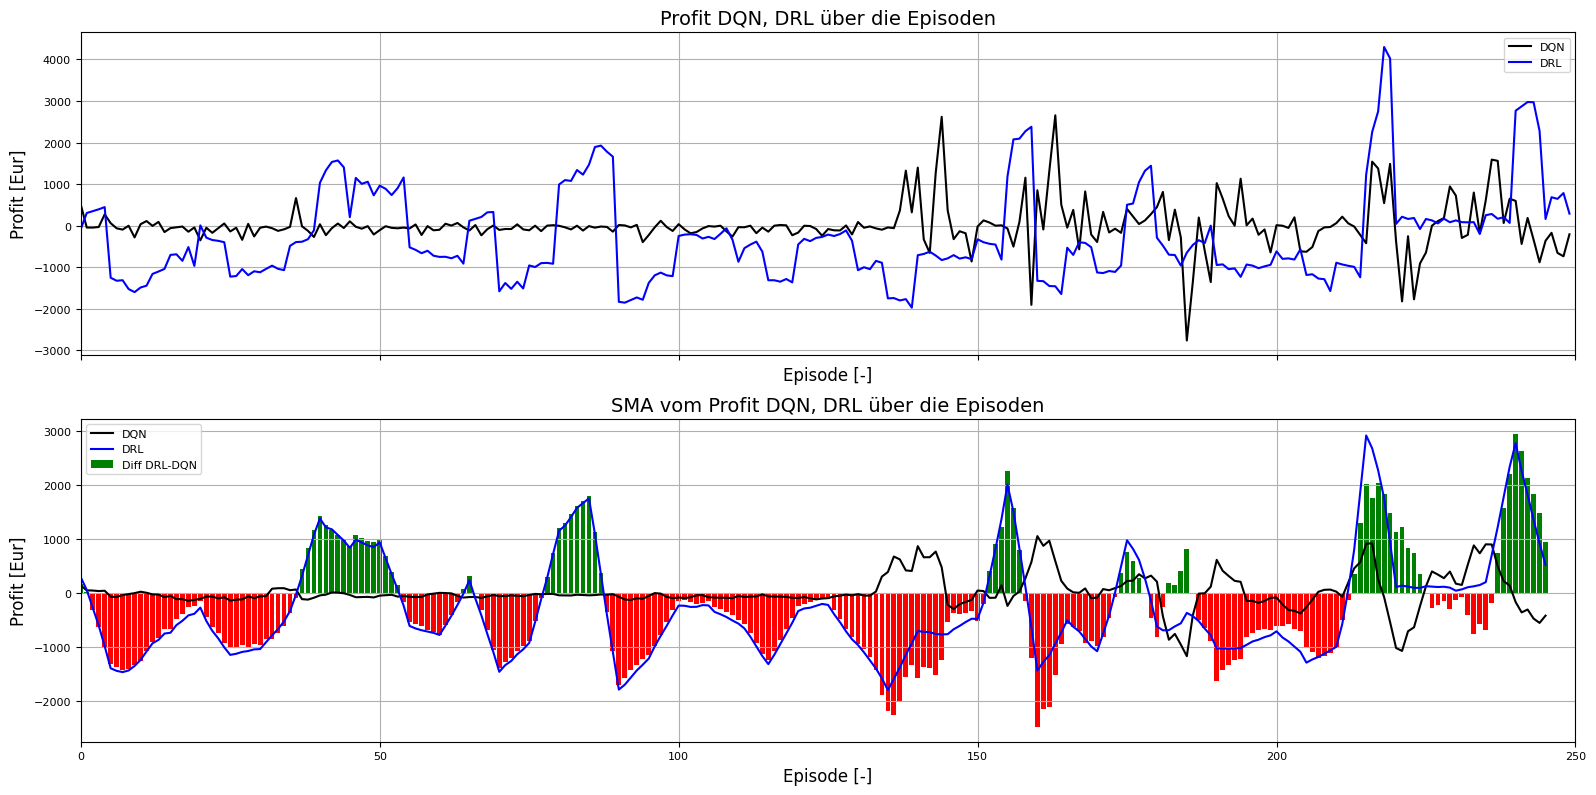

In [119]:
best_profit_dqn = dict_reward_plots['compute_reward_from_tutor']['profit']['dqn']
best_profit_drl = dict_reward_plots['reward_profit']['profit']['drl']
best_delta_btc_price_drl = [best_profit_drl[i] - best_profit_dqn[i] for i in range(len(episode_drl))]

plot_comparison_dqn_drl(episode_dqn, best_profit_dqn, best_profit_drl, best_delta_btc_price_drl, n_conv = n_convs, save_name='best_reward')